# Imbalanced Learning: A Study on Credit Card Fraud

__Notebook by [Ali Rifat Kaya](https://www.linkedin.com/in/alirifatkaya/)__

__It is recommended to [view this notebook in nbviewer]() for the best viewing experience.__

### Table of Contents

- [Introduction](#Introduction)
- [Required Libraries](#Required-Libraries)
- [Data Quality](#Data-Quality)
- [Data Cleaning](#Data-Cleaning)
- [Data Tidying](#Data-Tidying)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature Selection](#Feature-Selection)
- [The-Metrics](#The-Metrics)
- [Classification](#Classification)
    * [Prepare Data for Classification](#Prepare-Data-for-Classification)
    * [Cross-validation](#Cross-Validation)
    * [Hyperparameter Tuning](#Hyperparameter-Tuning)
        * [Logistic Regression](#Logistic-Regression)
        * [$k$-NN Classifier](#$k$-NN-Classifier)
        * [Decision Tree Classifier](#Decision-Tree-Classifier)
        * [Extra Trees Classifier](#Extra-Trees-Classifier)
        * [XGBoost Classifier](#XGBoost-Classifier)
* [Resampling Methods](#Resampling-Methods)
    * [SMOTEENN](#SMOTEENN)
    * [Cross-validation (Resampled)](#Cross-Validation-(Resampled))
* [Hyperparameter Tuning (Resampled)](#Hyperparameter-Tuning-(Resampled))
    * [Logistic Regression (Resampled)](#Logistic-Regression-(Resampled))
    * [$k$-NN Classifier (Resampled)](#$k$-NN-Classifier-(Resampled))
    * [Extra Trees Classifier (Resampled)](#Extra-Trees-Classifier-(Resampled))
    * [XGBoost Classifier (Resampled)](#XGBoost-Classifier-(Resampled))
* [Final Evaluation](#Final-Evaluation)
    * [Test Scores](#Test-Scores)
    * [Confusion Matrices](#Confusion-Matrices)
* [Remarks](#Remarks)

## Introduction

Credit or debit card fraud is a daily life issue that causes many people to suffer and a significant number of resources to be lost. It can happen to anyone in our society since we live in a digital world.

The below chart is from [The Nilson Report](https://nilsonreport.com/mention/407/1link/). It projects that the loss from card fraud will reach 40 Bil. \\$ in 2027. Even though the cents per 100 \\$ of total volume indicator begins to fall starting from 2015, the cost of card fraud increases steadily year by year. The indicator only shows that the growth rate of genuine transactions is greater than the fraudulent transactions.

<img src="https://nilsonreport.com/upload/Cover_Chart_1164.gif" width="300" height="400"/>
Source: https://nilsonreport.com/upload/Cover_Chart_1164.gif

This project aims to detect fraudulent card transactions by using machine learning algorithms. However, potential issues are misclassifying a fraudulent transaction (*false negative*) or a genuine transaction (*false positive*). In the case of a false negative, fraud happens, and the bank lost resources. On the other hand, in the case of a false positive, customer satisfaction will be negatively affected. However, there will be a trade-off between being fraud-proof and naive to assume that all transactions are genuine. I will try to optimize the tools to find the sweet spot where all parties will face the least damage. Nevertheless, the stakeholders' priorities are the most significant factor in determining the balance

[Go to Table of Contents](#Table-of-Contents)

## Libraries

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

* **NumPy**: Provides a fast numerical array structure and helper functions.
* **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
* **scikit-learn**: The essential Machine Learning package in Python.
* **xgboost**: Provides access to XGBoost algorithm using scikit-learn style.
* **imblearn**: Provides tools for dealing with imbalanced data sets.
* **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **Seaborn**: Advanced statistical plotting library.
* **pickle**: Stores data structures, trained models, etc. for further use.
* **warnings**: Handles warnings in the Python.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from IPython.core.display import display, HTML
from Documentation.my_module import *
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as imblearn_Pipeline
from sklearn.ensemble import VotingClassifier
warnings.filterwarnings('ignore') # silence warnings 
# display(HTML('<style>.container { width:80% !important; }</style>'))

In [2]:
def pr_auc_score(y_test, predicted_probabilities):
    """Return AUCPR (Area Under Curve Precision-Recall) score

    Parameters
    ----------

    y_test : Test set target values
        Example:
        # df is a pandas dataframe with features and target variable
        # where 'Class' is the target variable
        >>> import pandas as pd
        >>> from sklearn.model_selection import train_test_split

        >>> X = df.drop('Class', axis=1).values # input matrix
        >>> y = df['Class'].values # target array
        >>> X_train, X_test, y_train, y_test = train_test_split(X,
                                                                y,
                                                                test_size=0.3,
                                                                random_state=1)
        >>> # y_test is the target values for test set


    predicted_probabilities : Predicted probabilities for positive class
        Example:
        >>> from sklearn.linear_model import LogisticRegression
        >>> lr = LogisticRegression()
        >>> lr.fit(X_train, y_train)
        >>> predicted_probabilities = lr.predict_proba(X_test)[:, 1]


    Returns
    -------

    auc_score : The AUCPR score for the given target values and probabilities
    """
    precision, recall, threshold = precision_recall_curve(
        y_test, predicted_probabilities)
    auc_score = auc(recall, precision)

    return auc_score

In [3]:
# PR AUC scorer for cross_validate
aucpr_scorer = make_scorer(pr_auc_score, needs_proba=True)   

In [4]:
# Matthews Corrcoef scorer for cross_validate
matthews_scorer = make_scorer(matthews_corrcoef)

[Go to Table of Contents](#Table-of-Contents)

## Data Quality

In [5]:
raw_data = pd.read_csv('Documentation/data/creditcard.csv', header=0) # read data
# copy data into another dataframe by keeping the original in any case
df = raw_data.copy()
with pd.option_context('display.max_columns', None):
    display(df.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Great! The data is in a structured format.

The first row in the data file defines the column headers. The columns `v1` - `v28` are result of PCA (Principle Component Analysis). `Time` represents seconds passed from the beginning of the records. `Amount` is the transaction amount. `Class` is a binary variable, which indicates whether a transaction is fraudulent.

Even though data is collected chronologically, it is possible to assume that each transaction is independent from each other. For this reason, we can shuffle the data set to generate training and test sets.

Each row following the first row represents a credit card transaction.

Let's check for the missing data.


In [6]:
# gives info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

* It seems that there is no missing data. The total number of observations is 284,087. There are 31 features (28 of whom are PCA components). Also, each feature has `float64` or `int64` data type which is the right one for numerical data.

In [7]:
# gives numerical summary of the data
with pd.option_context('display.max_columns', None):
    display(df.describe().round(3))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000
mean,94813.860,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,88.350,0.002
std,47488.146,1.959,1.651,1.516,1.416,1.380,1.332,1.237,1.194,1.099,1.089,1.021,0.999,0.995,0.959,0.915,0.876,0.849,0.838,0.814,0.771,0.735,0.726,0.624,0.606,0.521,0.482,0.404,0.330,250.120,0.042
min,0.000,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,-24.588,-4.797,-18.684,-5.792,-19.214,-4.499,-14.130,-25.163,-9.499,-7.214,-54.498,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000,0.000
25%,54201.500,-0.920,-0.599,-0.890,-0.849,-0.692,-0.768,-0.554,-0.209,-0.643,-0.535,-0.762,-0.406,-0.649,-0.426,-0.583,-0.468,-0.484,-0.499,-0.456,-0.212,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,5.600,0.000
50%,84692.000,0.018,0.065,0.180,-0.020,-0.054,-0.274,0.040,0.022,-0.051,-0.093,-0.033,0.140,-0.014,0.051,0.048,0.066,-0.066,-0.004,0.004,-0.062,-0.029,0.007,-0.011,0.041,0.017,-0.052,0.001,0.011,22.000,0.000
75%,139320.500,1.316,0.804,1.027,0.743,0.612,0.399,0.570,0.327,0.597,0.454,0.740,0.618,0.663,0.493,0.649,0.523,0.400,0.501,0.459,0.133,0.186,0.529,0.148,0.440,0.351,0.241,0.091,0.078,77.165,0.000
max,172792.000,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,23.745,12.019,7.848,7.127,10.527,8.878,17.315,9.254,5.041,5.592,39.421,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,25691.160,1.000


* Provides a great amount of information about the data. All PCA components (`v1` - `v28`) are standardized (it is a feature of PCA). `Time` and `Amount` aren't standardized. The average amount of transactions (including card fraud) is 88.35 €.

[Go to Table of Contents](#Table-of-Contents)

## Data Cleaning

In [8]:
print("""
    Number of transactions with 0 €: {:,}
    Number of fraudulent transactions with 0 €: {}
    Number of genuine transactions with 0 €: {:,}
    
    The average amount (€) of transactions (including 0 € transactions): {:.2f} €
    The average amount (€) of transactions (excluding 0 € transactions): {:.2f} €
    """.format(df[df.Amount == 0].shape[0],
               df[(df.Class == 1) & (df.Amount == 0)].shape[0],
               df[(df.Class == 0) & (df.Amount == 0)].shape[0],
               df.Amount.mean(),
               df[df.Amount != 0].Amount.mean()))

# drop 0 € transactions
idx = np.zeros(df.shape[0], dtype=np.bool)
idx[df.Amount == 0] = True
idx = np.where(idx==True)
df.drop(idx[0], inplace=True)


    Number of transactions with 0 €: 1,825
    Number of fraudulent transactions with 0 €: 27
    Number of genuine transactions with 0 €: 1,798
    
    The average amount (€) of transactions (including 0 € transactions): 88.35 €
    The average amount (€) of transactions (excluding 0 € transactions): 88.92 €
    


[Go to Table of Contents](#Table-of-Contents)

## Data Tidying

In [9]:
# consolidate time into hours 
df['Hour'] = pd.to_datetime(df['Time'], unit='s').dt.hour

In [10]:
# split data by class
# datafrane includes only fraudulent transactions
df_fraud = df[df['Class'] == 1].reset_index(drop=True)
# dataframe includes only genuine transactions
df_genuine = df[df['Class'] == 0].reset_index(drop=True)

[Go to Table of Contents](#Table-of-Contents)

## Exploratory Data Analysis

In [11]:
# some statistics about fraudulent observations
print("""
    Minimum amount of fraudulent transaction is {:.2f} €.
    Maximum amount of fraudulent transaction is {:,.2f} €.
    There was a fraudulent transaction every {:0.2f} seconds.
    """.format(min(df_fraud['Amount']),
               max(df_fraud['Amount']),
               max(df['Time'])/df_fraud.shape[0]))


    Minimum amount of fraudulent transaction is 0.01 €.
    Maximum amount of fraudulent transaction is 2,125.87 €.
    There was a fraudulent transaction every 371.60 seconds.
    


In [12]:
# some statistics about genuine transactions
print("""
    Minimum amount of genuine transaction is {:.2f} €.
    Maximum amount of genuine transaction is {:,.2f} €.
    There was a genuine transaction every {:0.2f} seconds.
    """.format(min(df_genuine['Amount']),
               max(df_genuine['Amount']),
               max(df['Time'])/df_genuine.shape[0]))


    Minimum amount of genuine transaction is 0.01 €.
    Maximum amount of genuine transaction is 25,691.16 €.
    There was a genuine transaction every 0.61 seconds.
    


In [13]:
# some statistics about amounts
print(f"""
    The average amount of fraudulent transactions: {
df_fraud['Amount'].mean():,.2f} €
    The median amount of fraudulent transactions: {
df_fraud['Amount'].median():,.2f} €
    
    The average amount of genuine transactions: {
df_genuine['Amount'].mean():,.2f} €
    The median amount of genuine transactions: {
df_genuine['Amount'].median():,.2f} €
    """)


    The average amount of fraudulent transactions: 129.31 €
    The median amount of fraudulent transactions: 17.06 €
    
    The average amount of genuine transactions: 88.85 €
    The median amount of genuine transactions: 22.49 €
    


In [14]:
count_fraudulent = "{:,}".format(df_fraud.shape[0])
count_genuine = "{:,}".format(df_genuine.shape[0])
percent_fraudulent = "{:,.2f}%".format(df_fraud.shape[0] * 100 / df.shape[0])
percent_genuine = "{:,.2f}%".format(df_genuine.shape[0] * 100 / df.shape[0])

style = """{0:>15} \t {1:>23} \t {2:>14}"""

print('\n' + style.format('Transaction Type', 'Number of Transactions',
                          'Distributions'))
print(style.format('----------------', '----------------------',
                          '-------------'))
print(style.format('Genuine', count_genuine, percent_genuine))
print(style.format('Fraudulent', count_fraudulent, percent_fraudulent),
      end='\n\n')

# An extremely imbalanced dataset. 
# The positive class is only a tiny portion of the dataset.


Transaction Type 	  Number of Transactions 	  Distributions
---------------- 	  ---------------------- 	  -------------
        Genuine 	                 282,517 	         99.84%
     Fraudulent 	                     465 	          0.16%



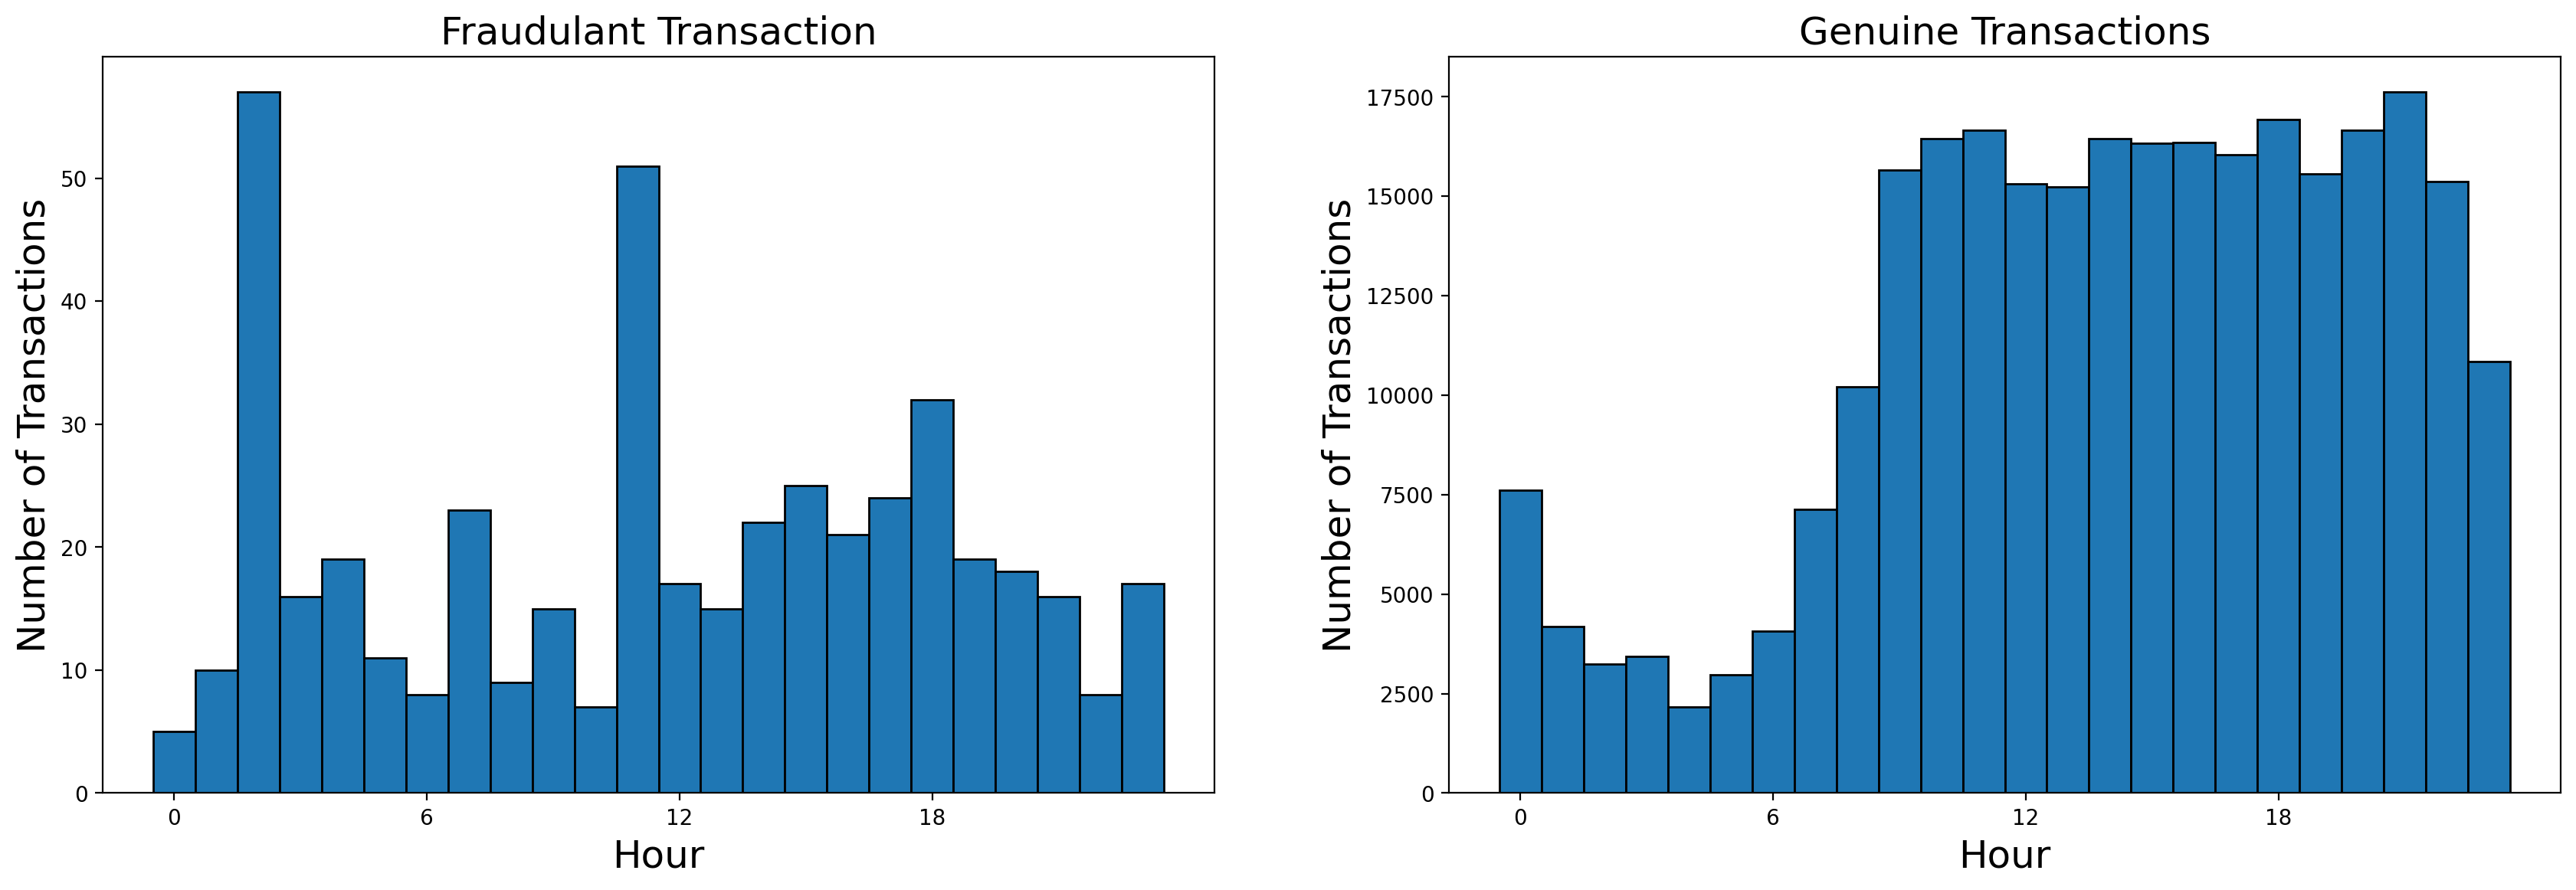

In [15]:
# Histograms of time in hours of genuine and fraudulent data
# (#row, # columns of plots - generate two side-to-side plots)
fig, axes = plt.subplots(1, 2)
fig.set_size_inches([18, 7])  # set the sizes in inches
fig.set_dpi(200)  # set the resolution of the plot
bins = np.arange(25) - 0.5 # set the edges for the bins
# plot histogram of time for the fraudulent transactions to the subplot on the left
axes[0].hist(df_fraud['Hour'], bins=bins, edgecolor='k')
axes[0].set_title('Fraudulant Transaction', size=18)
# plot the histogram of time for the genuine transactions to the subplot on the right
axes[1].hist(df_genuine['Hour'], bins=bins, edgecolor='k')
axes[1].set_title('Genuine Transactions', size=18)

for i in range(2):
    axes[i].set_xticks(np.arange(0, 24, 6))
    axes[i].set_xlabel('Hour', size=18)  # set the label on the x-axis
    axes[i].set_ylabel('Number of Transactions', size=18)

# nice look to the figure
plt.tight_layout(5)
# shows the plot
fig.savefig('Documentation/images/hour_histogram.jpg', dpi=100)

* While the *genuine* transactions have an expected 'Time' histogram, the majority of the transactions occur in the day time, the *fraudulent* transactions does not have the same pattern. This may be due to the limited number of samples from the positive class.

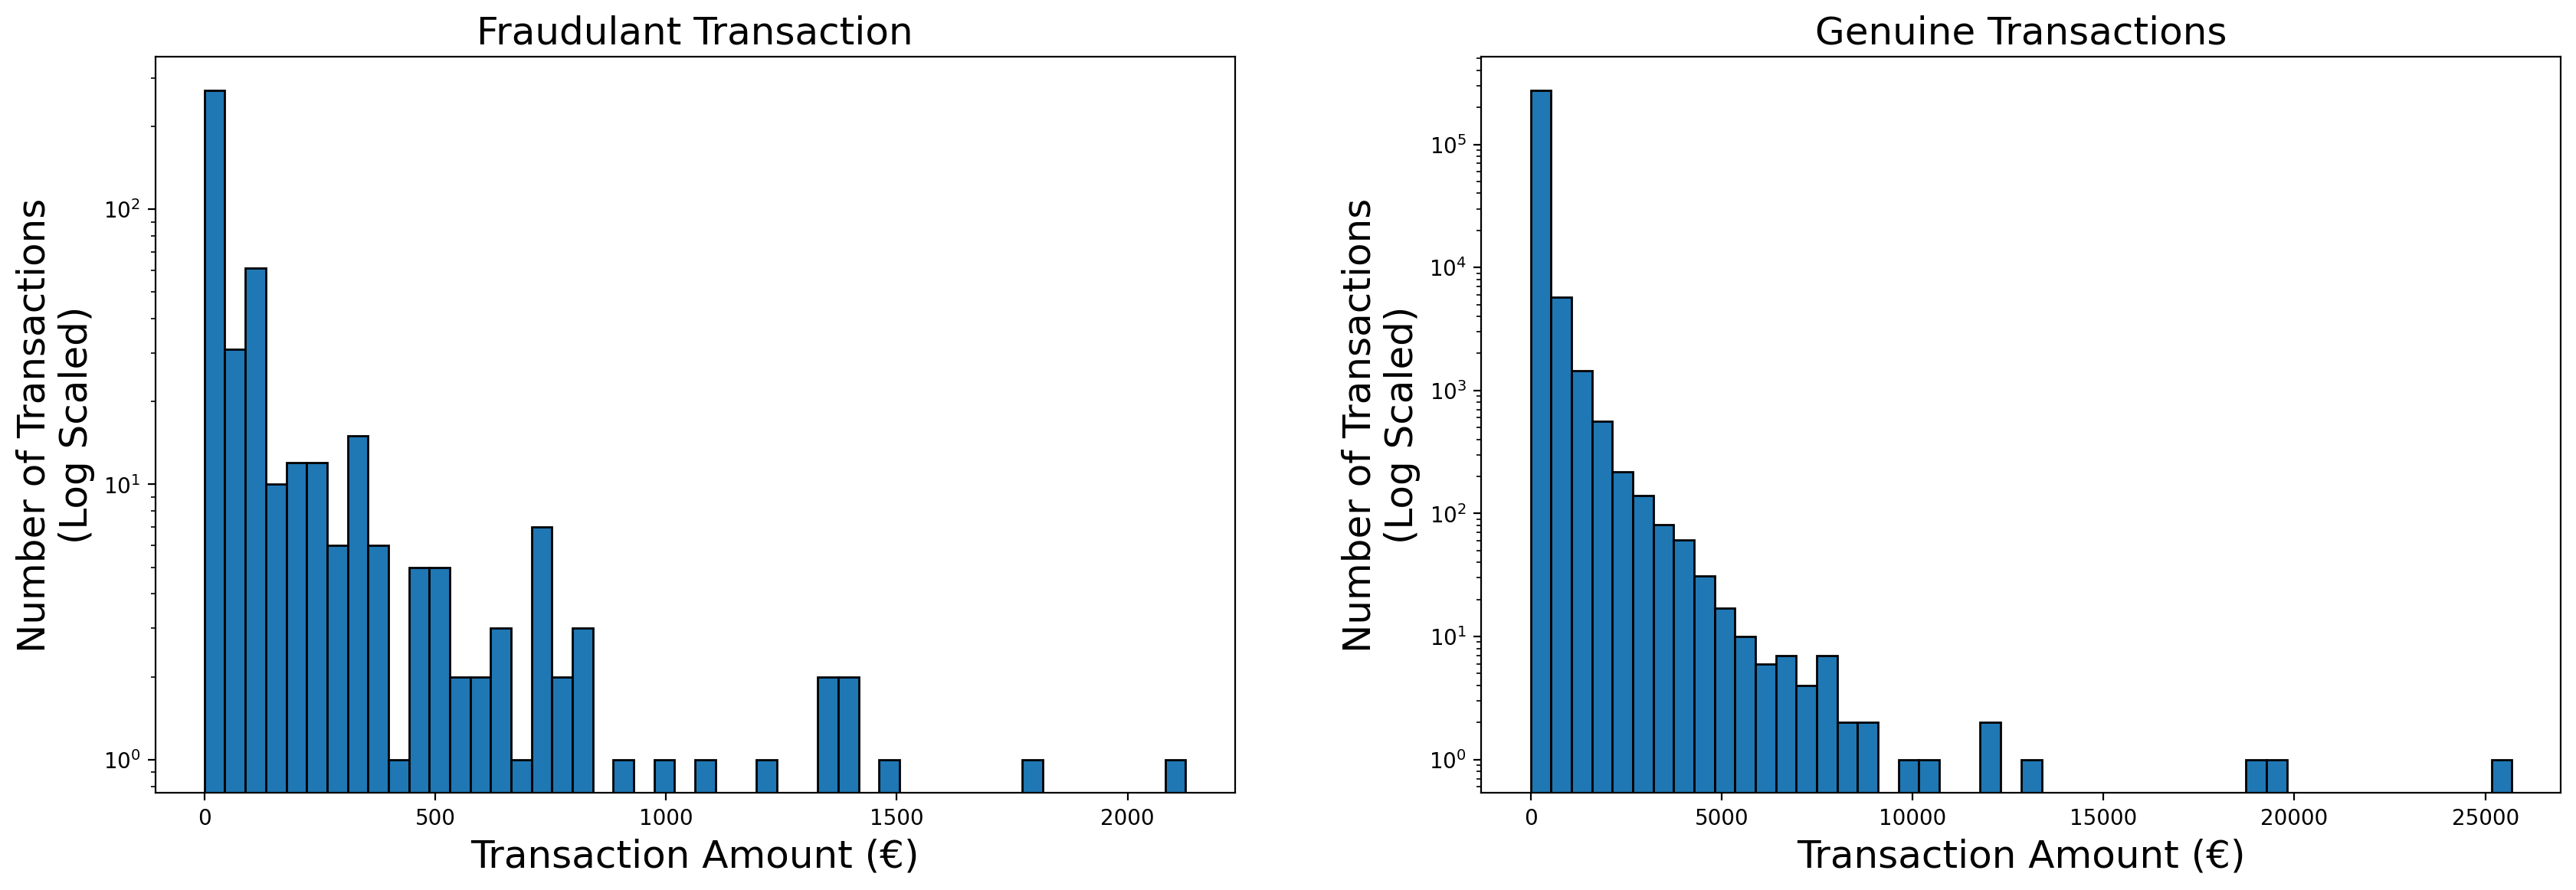

In [16]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches([18, 7])
fig.set_dpi(200)

axes[0].hist(df_fraud['Amount'], bins=48, edgecolor='k')
axes[0].set_title('Fraudulant Transaction', size=18)
axes[1].hist(df_genuine['Amount'], bins=48, edgecolor='k')
axes[1].set_title('Genuine Transactions', size=18)

for i in range(2):
    axes[i].set_yscale('log')
    axes[i].set_xlabel('Transaction Amount (€)', size=18)
    axes[i].set_ylabel('Number of Transactions\n(Log Scaled)', size=18)
    
plt.tight_layout(5)
fig.savefig('Documentation/images/amount_histogram.jpg', dpi=100)

* In the `df_genuine`, the distribution is right-skewed. It is expected because most people use credit card for small/medium size purchases and a few people do huge transactions.
* In the `df_fraud`, we see the same pattern as in the genuine transactions. It may be due to an effort to benefit stolen cards for a long period of time by keeping the amounts tiny.

[Go to Table of Contents](#Table-of-Contents)

## Feature Selection

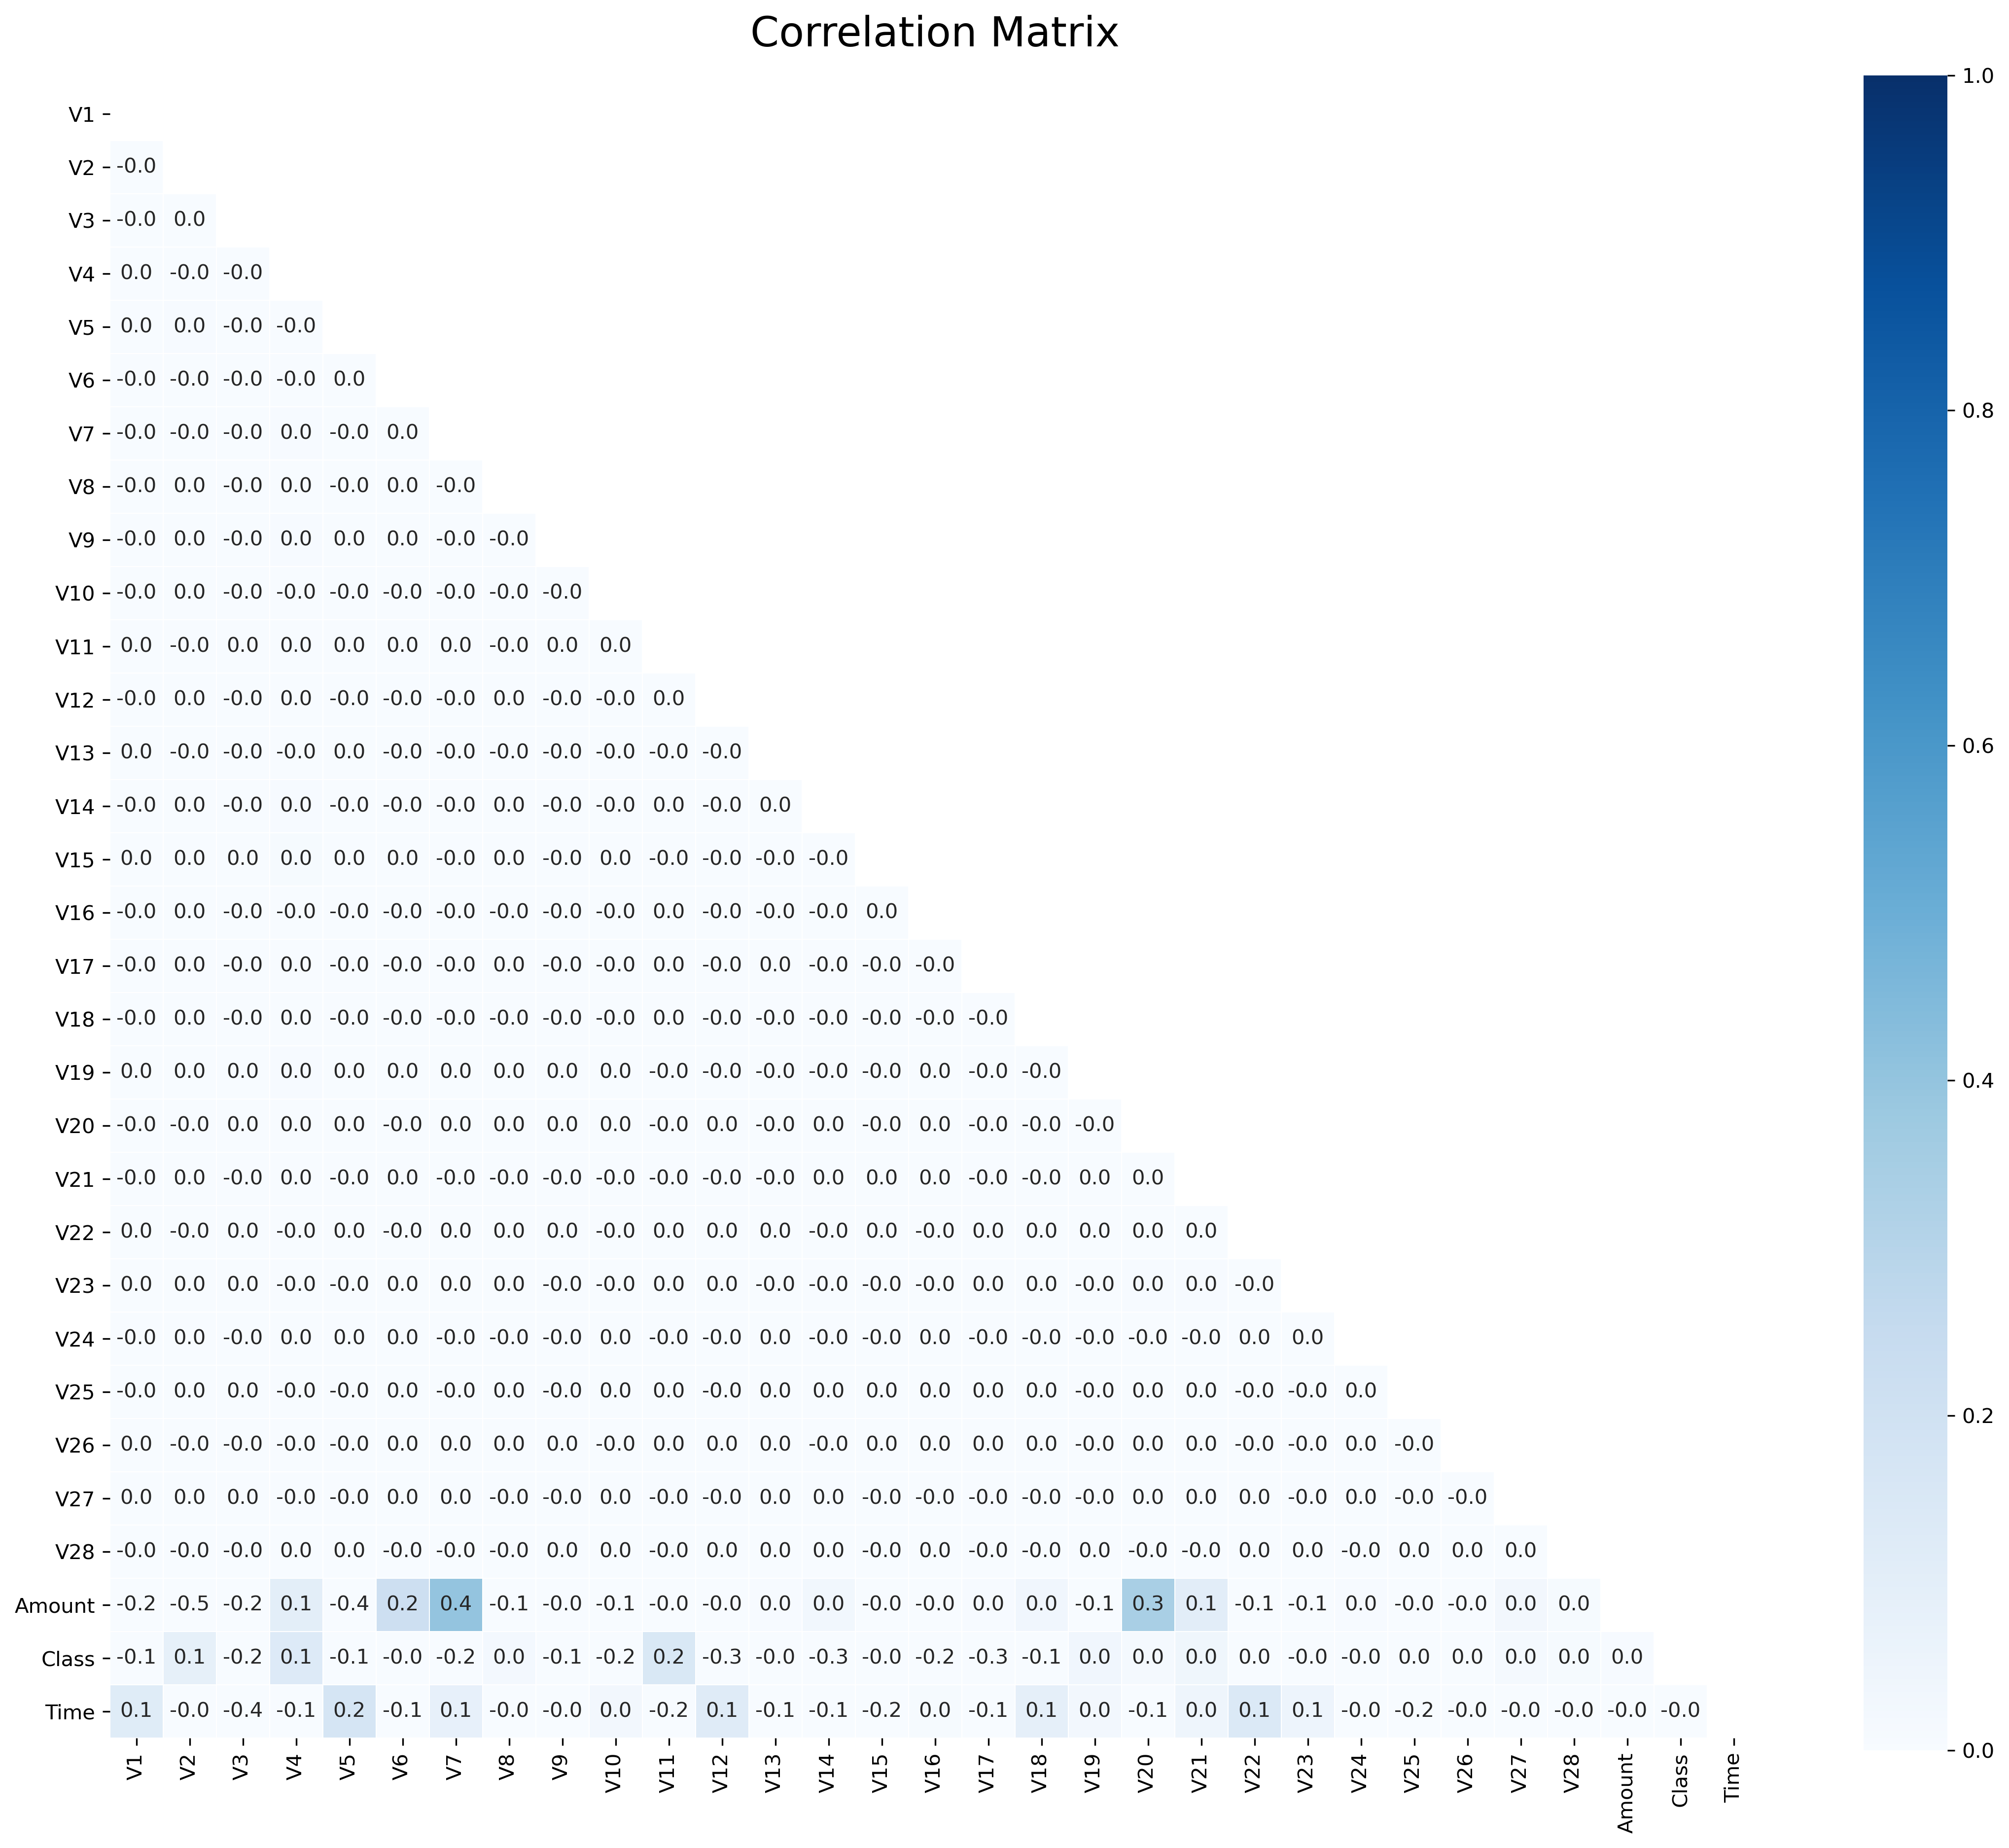

In [17]:
# inspect correlation among features
# this step will prove that all features V1-V28 have 0 correlation
# since the features are generated by PCA and are orthogonal to each other
# also further examine if there is any correlation exist between any
# component and either of 'Time', 'Amount', 'Class' features.

# takes all columns (including `Time`) - except `Hours`
# feature list starts with components
feature_names = list(df.drop(['Hour', 'Time'], axis=1).columns)
feature_names.append('Time')

fig, axes = plt.subplots()  # generates ax and figure object
fig.set_size_inches([18, 15])  # set the figure sizes in inches
fig.set_dpi(300)  # set the resolution of the figure

corr = df[feature_names].corr()  # generates the correlation matrix
# generates a numpy matrix of zeros with the size of the correlation matrix
mask = np.zeros_like(corr)
# the heatmap will not show the cells where the mask is True
# (https://seaborn.pydata.org/generated/seaborn.heatmap.html)
mask[np.triu_indices_from(mask)] = True  # shows only the left lower triangle

# plots the heatmap
ax = sns.heatmap(corr, mask=mask,
                 vmin=0, vmax=1,
                 linewidth=0.2, square=True, cmap='Blues',
                 annot=True, fmt='.1f')
#set title for the figure
ax.set_title('Correlation Matrix', size=20, pad=20)
# shows the plot
fig.savefig('Documentation/images/correlation_heatmap.jpg', dpi=100)

# # adjusts the heights of the top and bottom squares of the heatmap
# # matplotlib 3.1.1 has a bug that shows only the half of the top
# # and bottom rows of the heatmap
# bottom, top = ax.get_ylim()
# _ = ax.set_ylim(bottom + 0.5, top - 0.5)

* As expected, the features `v1` - `v28` are orthogonal, which means that there is no correlation among the features.
* There is a weak correlation between `v7` - `Amount` and `v20` - `Amount`. It may worth to look at the scatterplots. The remaining pair of relationships don't reveal a pattern in the data.

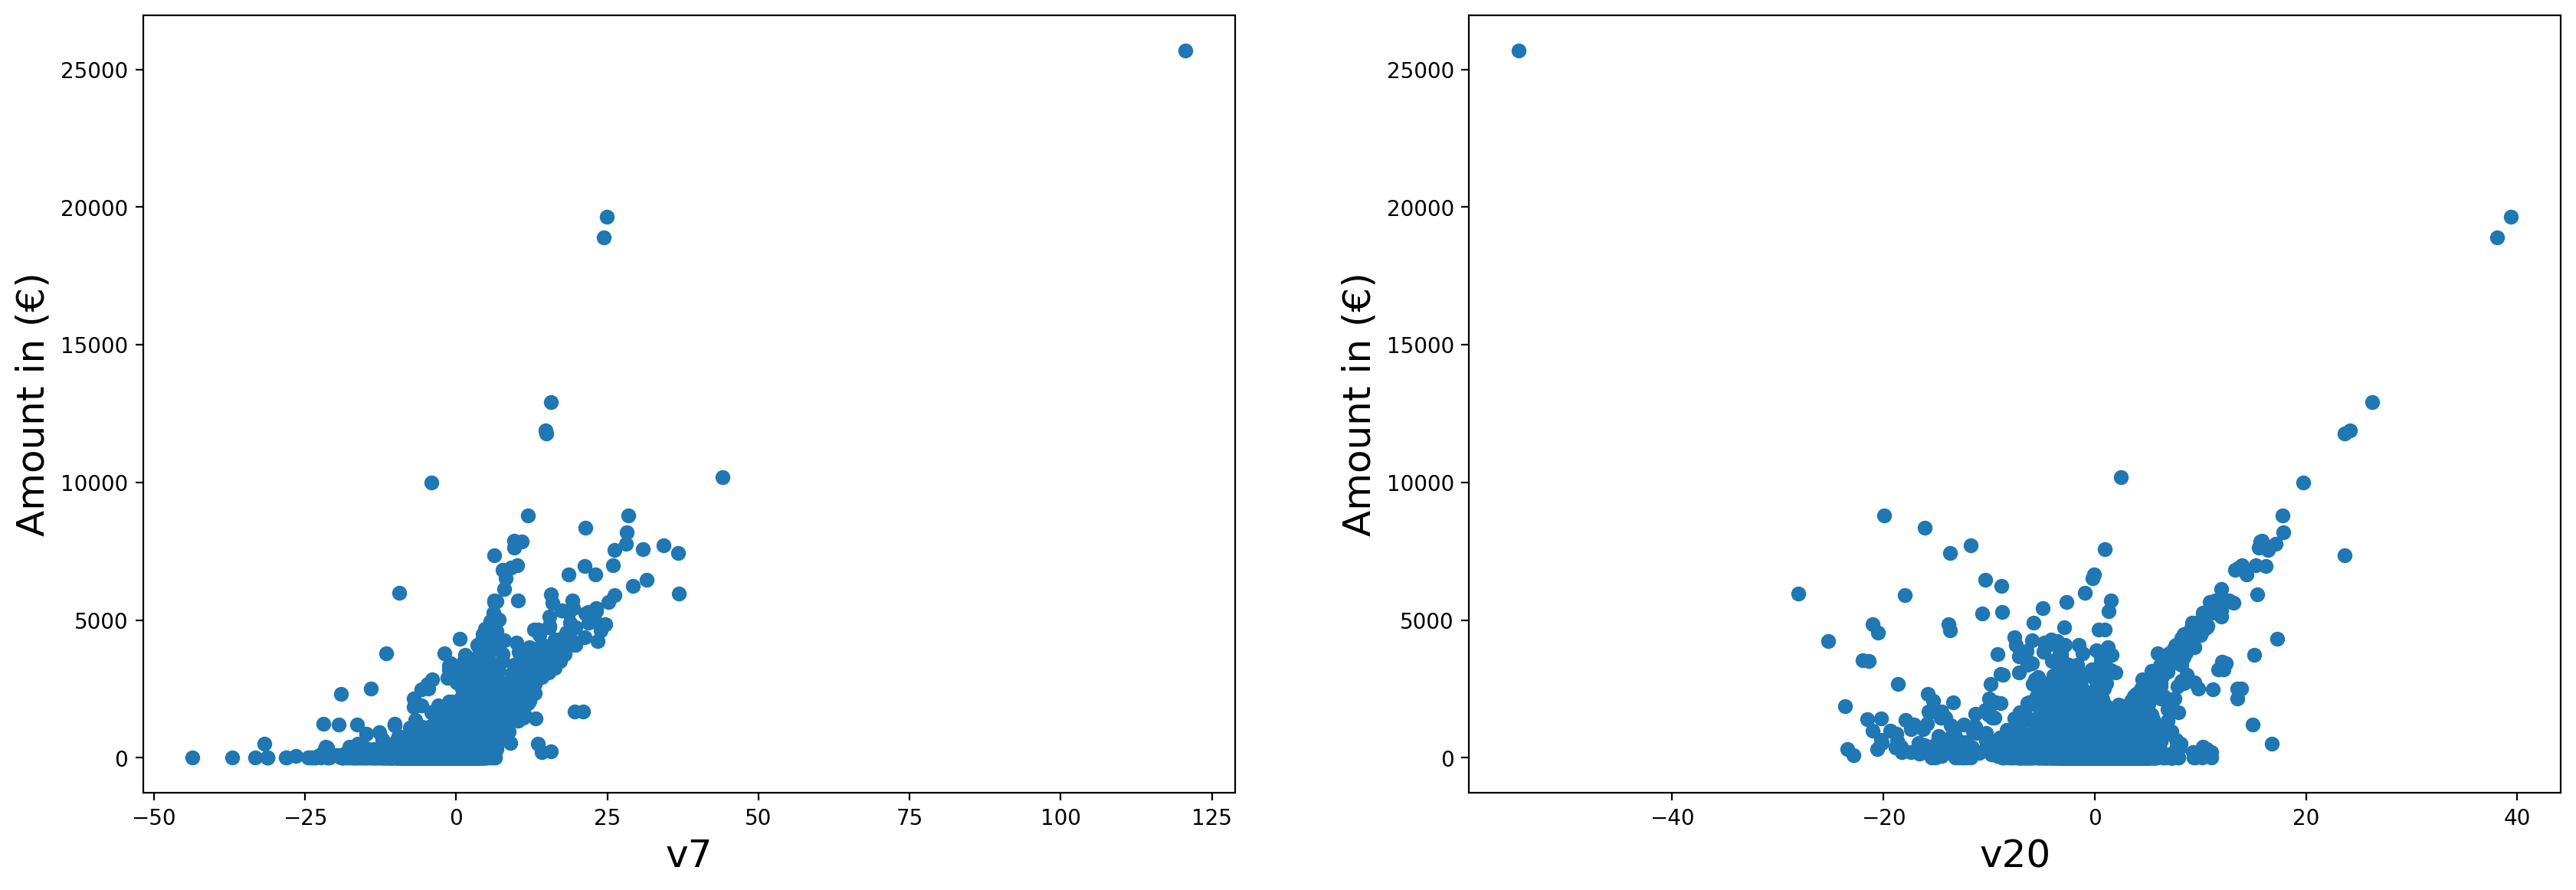

In [18]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches([18, 7])  # set the sizes in inches
fig.set_dpi(200)  # set the resolution of the plot

axes[0].scatter(df['V7'], df['Amount'])
axes[0].set_xlabel('v7', size=18)
axes[0].set_ylabel(r'Amount in (€)', size=18)

axes[1].scatter(df['V20'], df['Amount'])
axes[1].set_xlabel('v20', size=18)
axes[1].set_ylabel(r'Amount in (€)', size=18)

plt.tight_layout(5)
fig.savefig('Documentation/images/scatterplots.jpg', dpi=100)

* The correlation coefficients are inflated due to extreme values. This pattern is clearer in the relationship between `v20` - `Amount`.

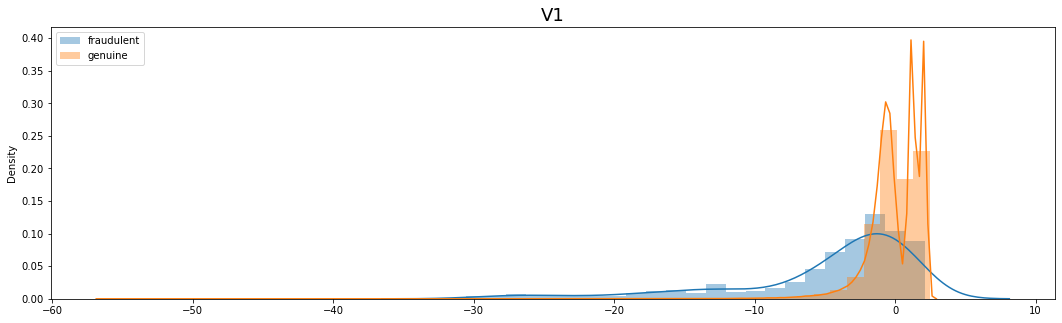

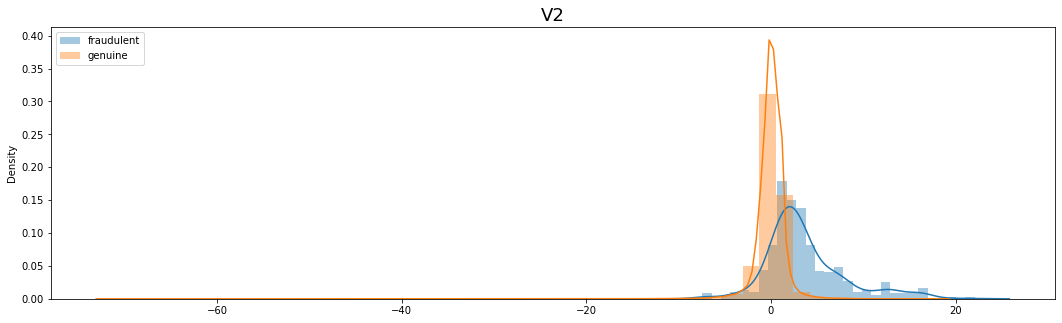

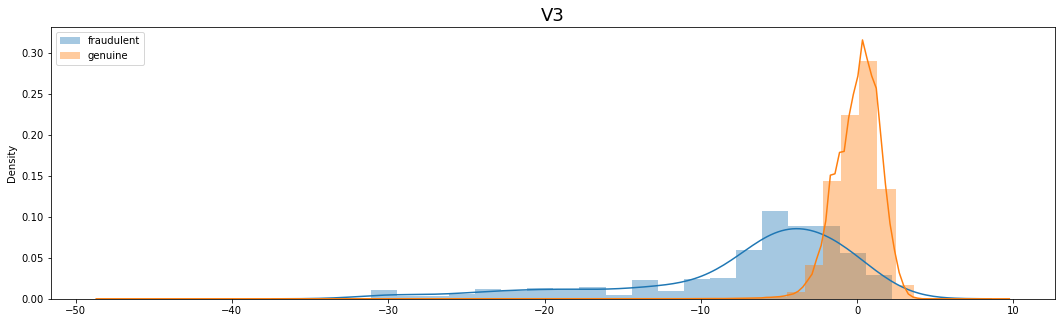

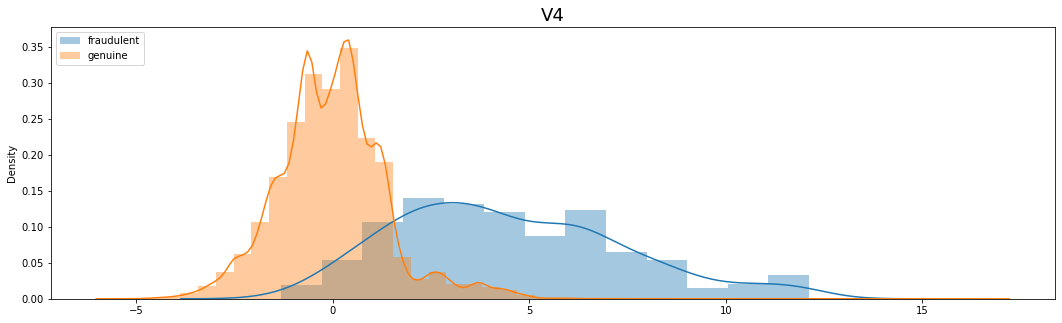

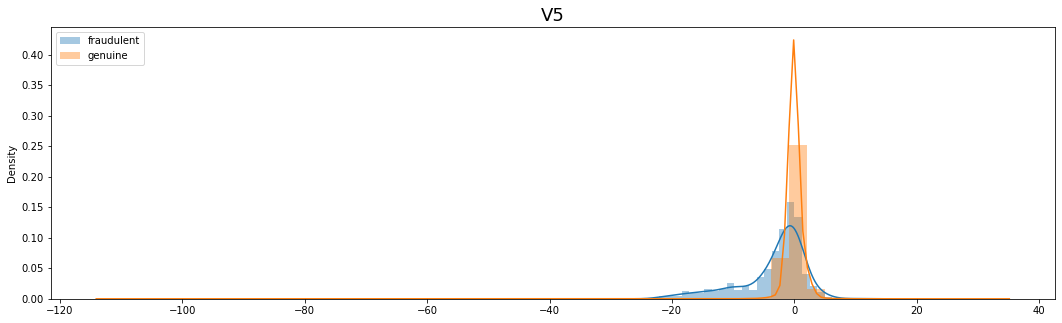

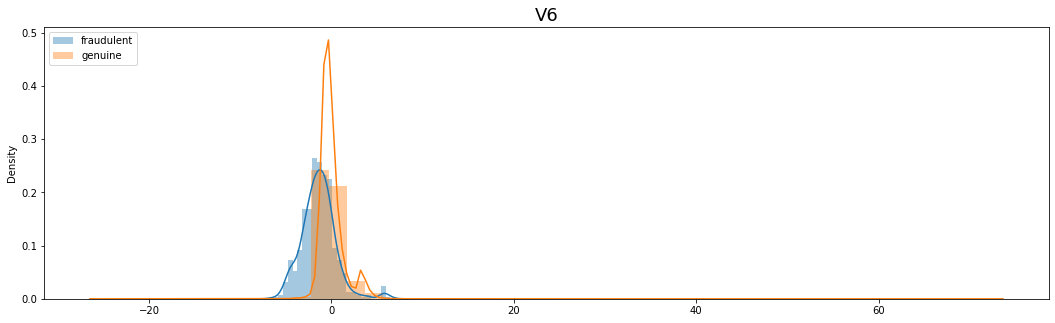

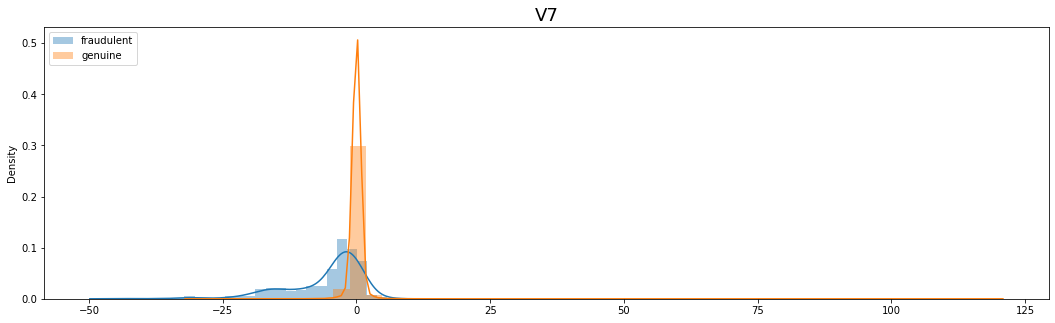

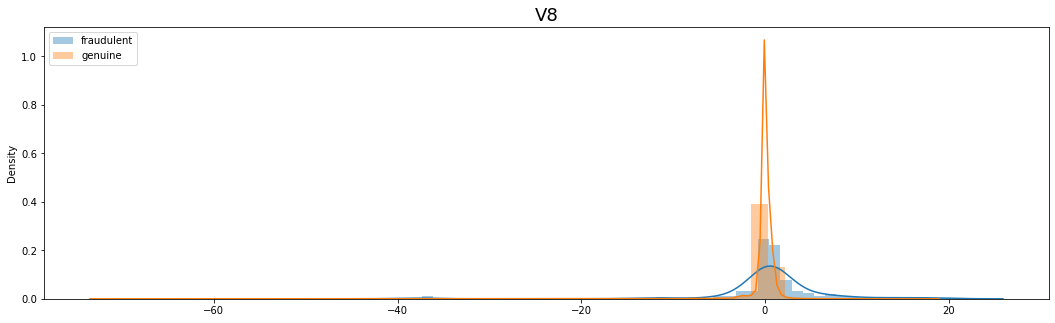

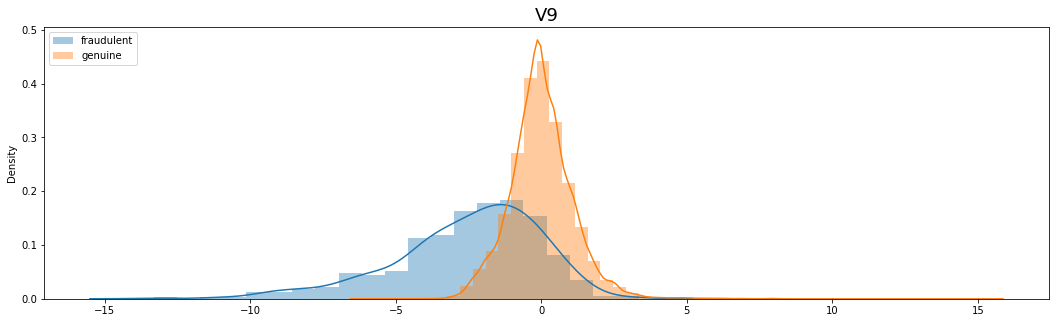

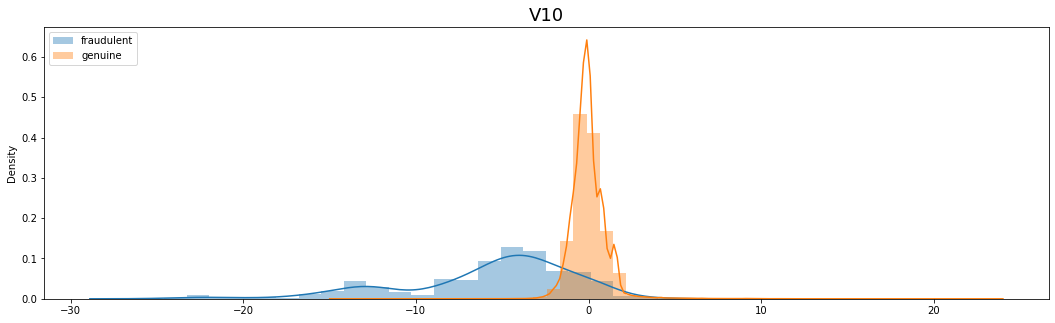

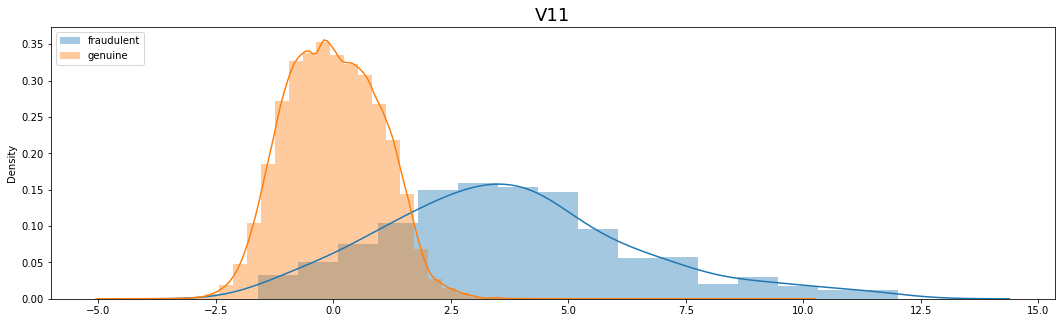

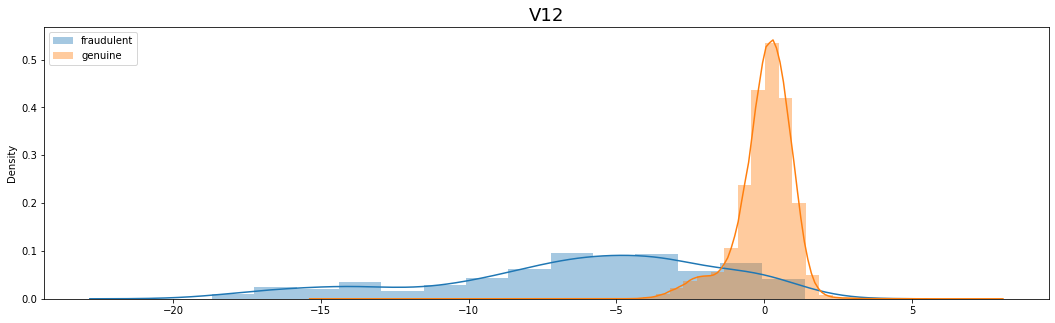

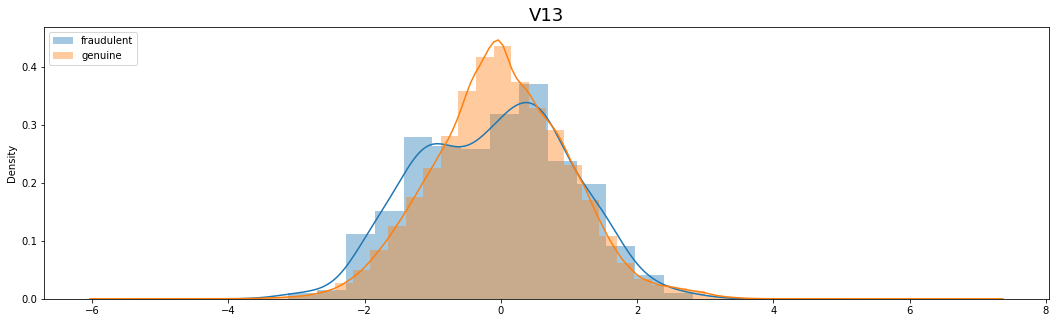

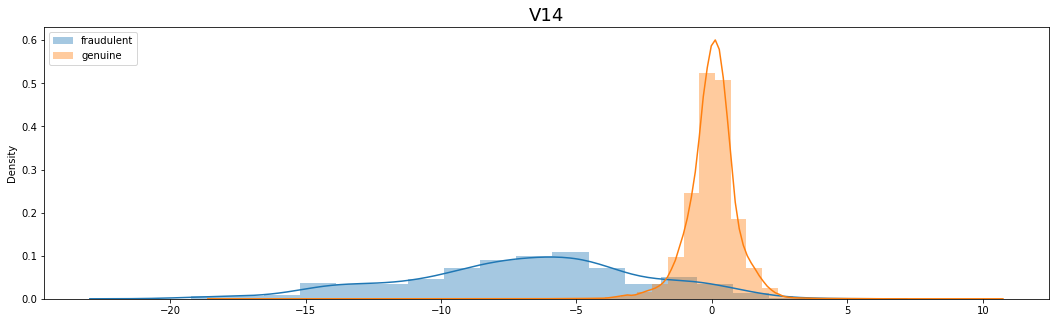

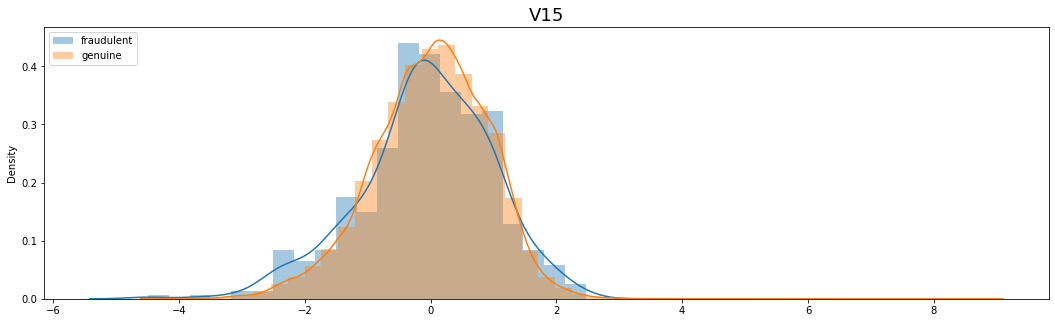

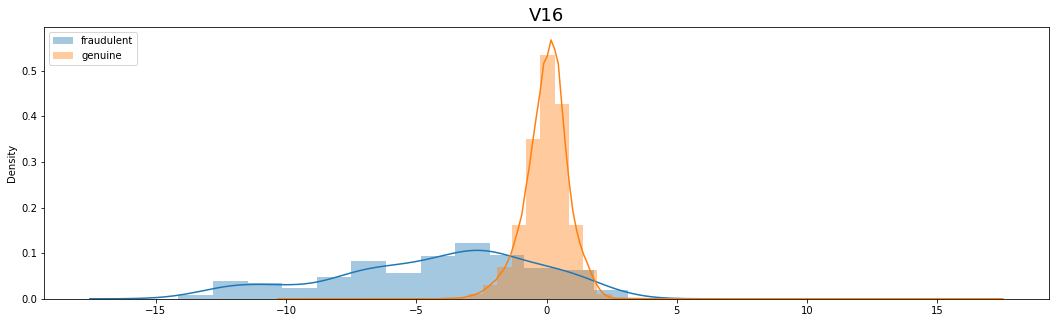

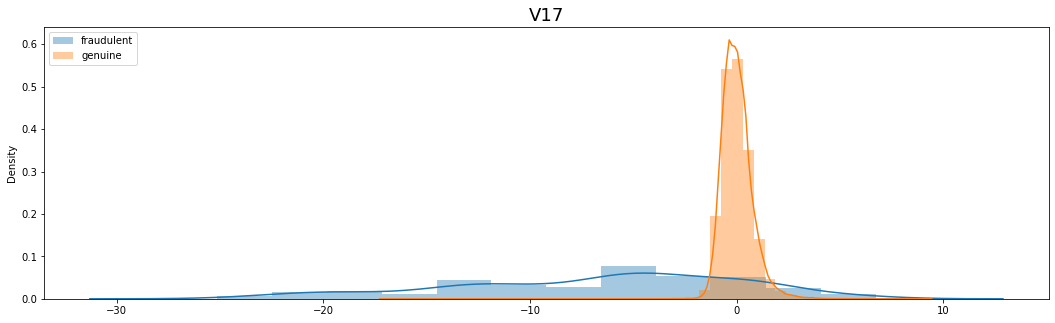

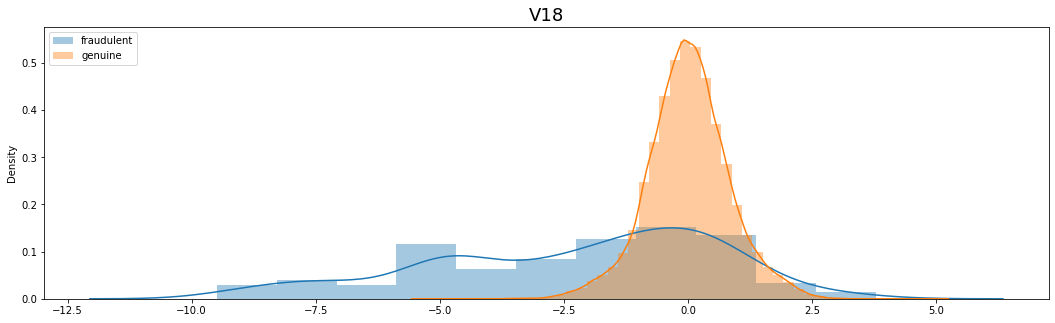

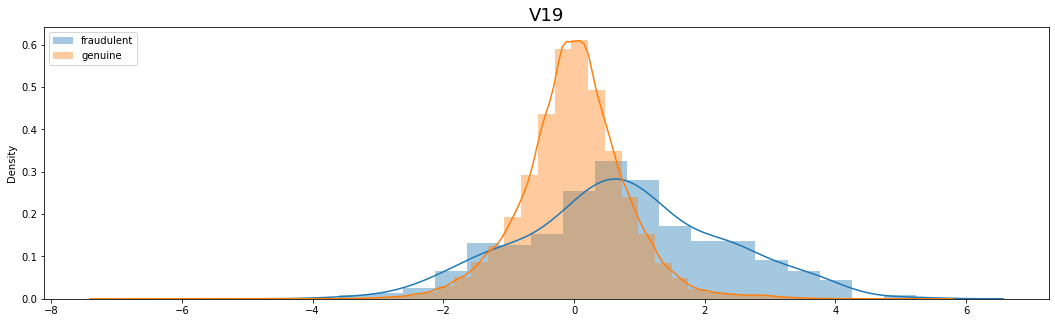

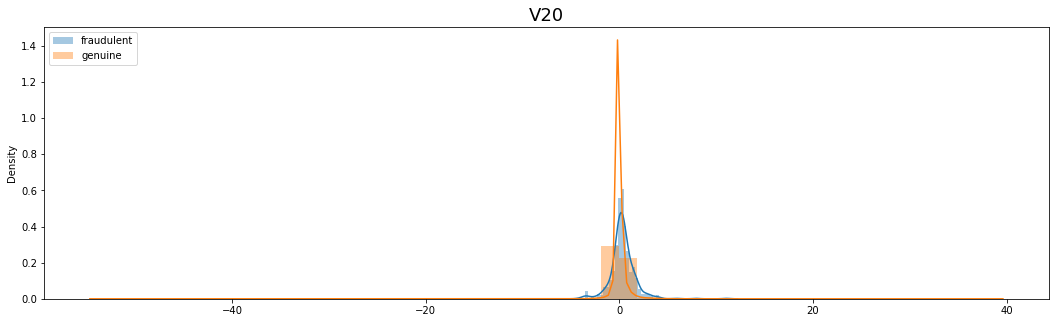

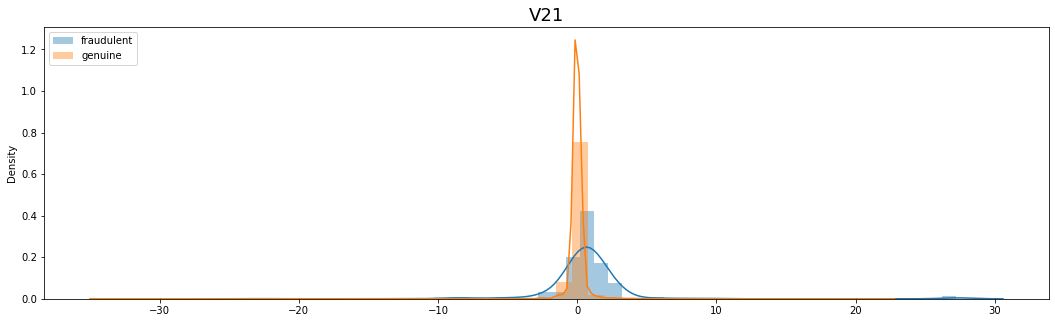

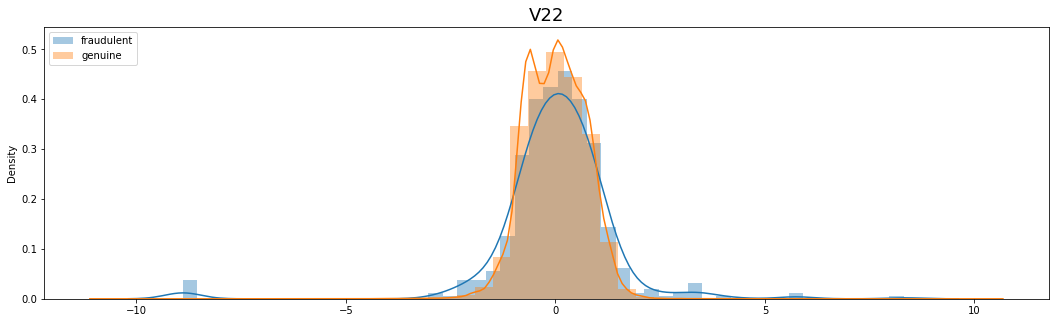

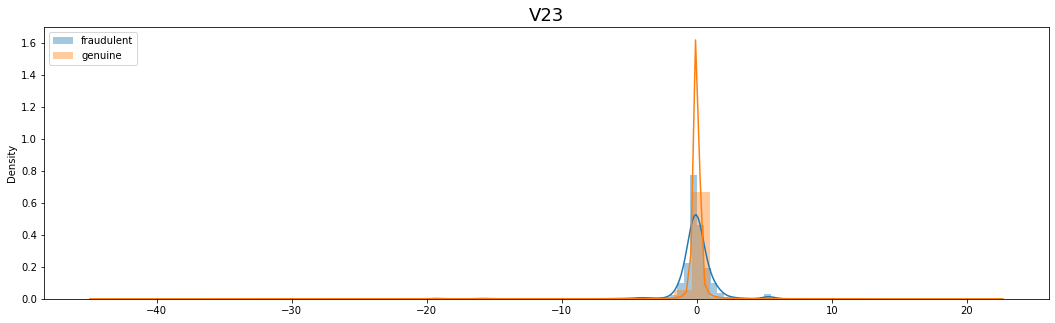

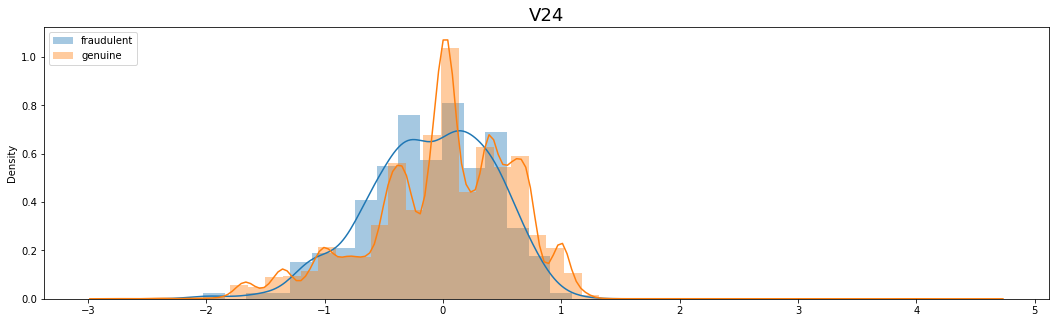

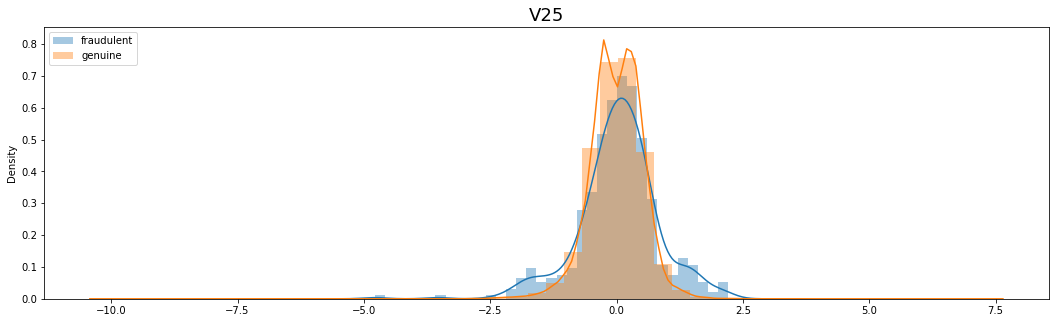

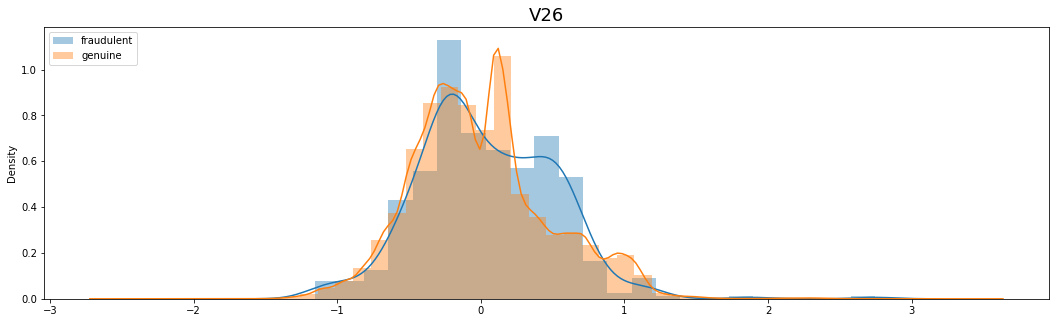

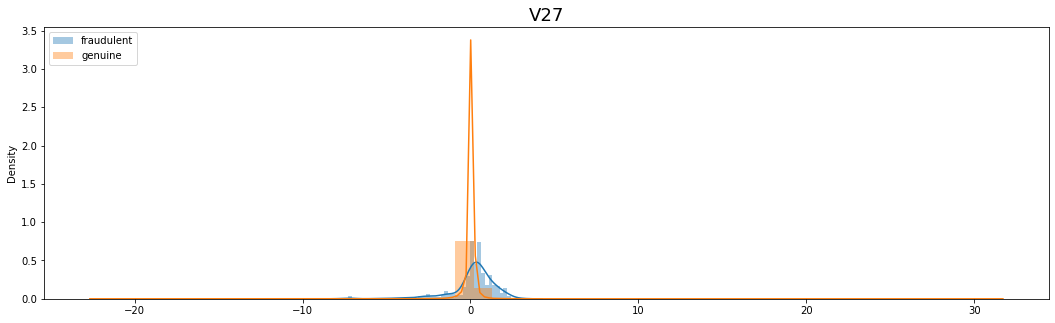

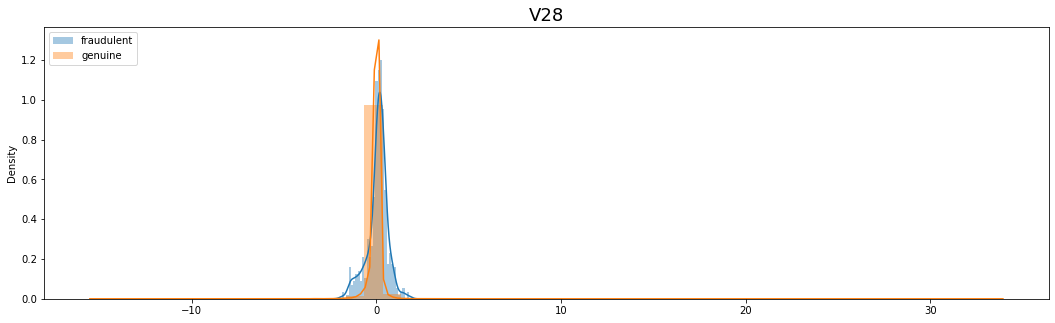

In [19]:
features = df.iloc[:,1:29].columns # PCA components
# compare distributions of features by class in order to find the
# features that can identify fraudulent transactions
for feature in features:
    fig, ax = plt.subplots() # generates figure and axis objects
    fig.set_size_inches([18,5]) # adjust the figure size in inches
    # plot the distribution of fraudulent transactions on the axis
    sns.distplot(df_fraud[feature], label='fraudulent', axlabel='', ax=ax)
    # plt the distribution of genuine transactions on the axis
    sns.distplot(df_genuine[feature], label='genuine', axlabel='', ax=ax)
    # set the title
    ax.set_title(f'{feature}', size=18)
    # shows the legend - contains labels
    ax.legend(loc='upper left')
    if feature in ['V15', 'V17']:
        fig.savefig(f'Documentation/images/bivariate/{feature}.jpg', dpi=100)

* It may be possible to predict fraudulent transactions based on features such as `v3`, `v4`, `v9`, `v10`, `v11`, `v12`, `v14`, `v16`, `v17`, and `v18`.

In [20]:
# In bivariate analysis, v15 has approximately identical distributions for each
# class. For this reason, we will use v15 for base to compare classes while
# constructing scatterplots.
X = df.drop(['Time', 'Amount', 'Class', 'Hour'], axis=1).values
y = df.Class.values

all_components = np.arange(1, X.shape[1] + 1)
base_feature = 15
features_fraudulent = [3, 4, 9, 10, 11, 12, 14, 16, 17, 18]
features_genuine = [
    feature for feature in all_components
    if feature not in features_fraudulent]
features_genuine.remove(base_feature)

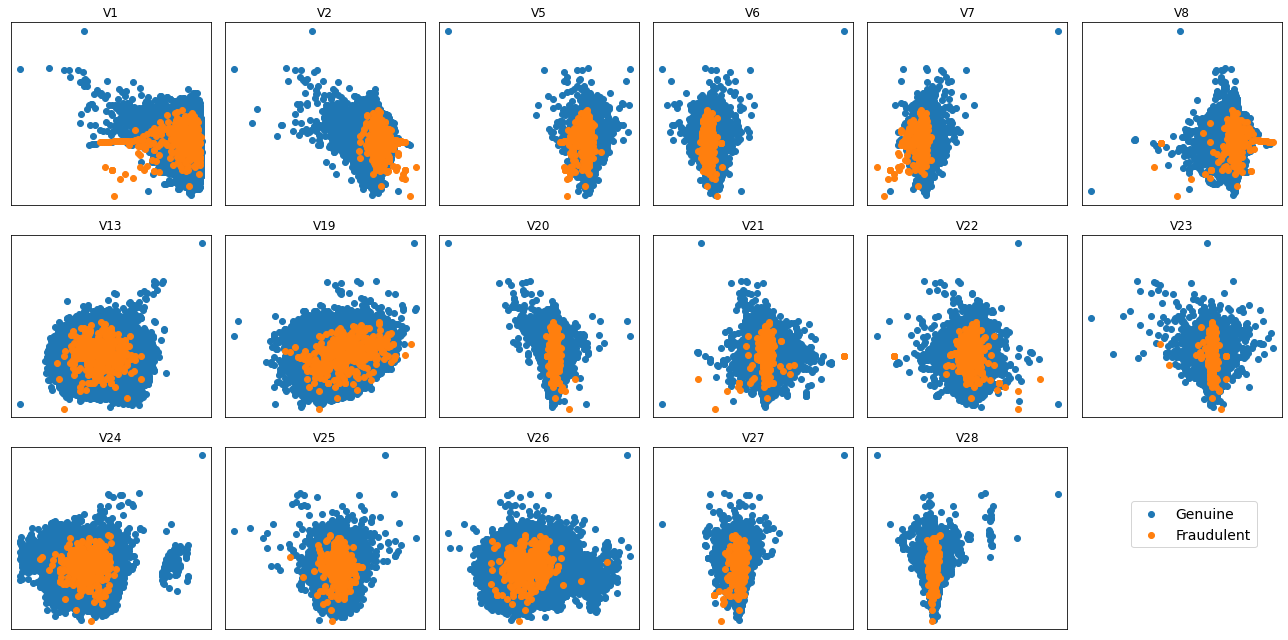

In [21]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
axes = axes.ravel()

for i, feature in zip(np.arange(len(axes)), features_genuine):
    for label in [0, 1]:
        idx = np.where(y == label)[0]
        # because of 0-indexing, we subtract 1 from feature value
        axes[i].scatter(X[idx, feature - 1], X[idx, base_feature - 1])
        axes[i].set_yticks([])
        axes[i].set_xticks([])
        axes[i].set_title(f'V{feature}')

fig.delaxes(axes[-1])
plt.figlegend(['Genuine', 'Fraudulent'], bbox_to_anchor=(0.975, 0.225), fontsize=14)
plt.tight_layout()
fig.savefig('Documentation/images/scatters_normal.png', dpi=100)

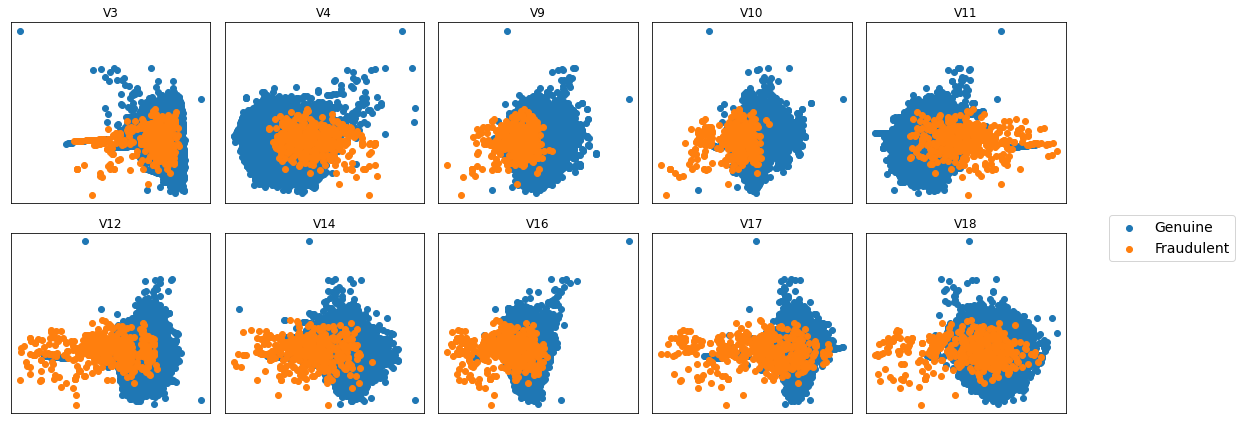

In [22]:
fig, axes = plt.subplots(2,5, figsize=(15, 6))
axes = axes.ravel()
for i, feature in zip(np.arange(len(axes)), features_fraudulent):
    for label in [0, 1]:
        idx = np.where(y == label)[0]
        axes[i].scatter(X[idx, feature - 1], X[idx, base_feature - 1])
        axes[i].set_yticks([])
        axes[i].set_xticks([])
        axes[i].set_title(f'V{feature}')
            
plt.figlegend(['Genuine', 'Fraudulent'], bbox_to_anchor=(1.15, 0.5), fontsize=14)
plt.tight_layout()
fig.savefig('Documentation/images/scatters_distinguish.jpg',
            bbox_inches='tight', dpi=100)

* In the first set of scatterplots, fraudulent transactions are disguised among genuine transactions. However, it the second set of scatterplots, we see that they are more distinguished.

[Go to Table of Contents](#Table-of-Contents)

## The Metrics

Before I dive into predictive analysis, I want to mention the evaluation metrics. To have a better understanding, let's start from the *Confusion Matrix*, which is the numerical summary of the algorithm's performance.

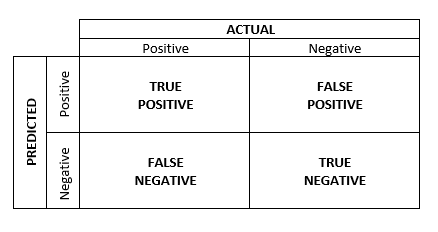

* In the light of credit card fraud detection problem:
    * __True Negative (TN)__: Transactions that are genuine and classified as genuine. 
    * __False Negative (FP)__: Transactions that are fraudulent but classified as genuine. 
    * __True Positive (TP)__: Transactions that are fraudulent and classified as fraudulent. 
    * __False Positive (FP)__: Transactions that are genuine but classified as fraudulent. 

---
* __Accuracy__: What percent of all transactions are classified correctly? $\frac{TP + TN}{TP + FP + TN + FN}$

* __Precision__: What percent of transactions that are predicted to be fraudulent are classified correctly? $\frac{TP}{FP + TP}$

* __Recall (Sensitivity)__: What percent of (actual) fraudulent transactions are classified correctly? $\frac{TP}{FN + TP}$

* __Specificity__: What percent of (actual) genuine transactions are classified correctly? $\frac{TN}{TN + FP}$

* __F1 Score__: Weighted average of Recall and Precision. $2*\frac{\text{Precision}*\text{Recall}}{\text{Precision}+\text{Recall}} = \frac{TP}{TP + \frac{1}{2}(FP + FN)}$

* __F-$\beta$ Score__: Weighted average of the Recall and Precision. As $\beta$ increases it puts more weights on Recall; otherwise it puts more weight on Precision. $\frac{(1+\beta^{2})*\text{Precision}*\text{Recall}}{\beta^{2}*\text{Precision}+\text{Recall}}$

* __Geometric Mean__: Balances Sensitivity and Specificity by taking the square root of the multiplication of both. $\sqrt{\text{Recall}*\text{Specificity}}$

* __Matthews CC (Correlation Coefficient)__: A measure of the quality of classifications. $\frac{\text{TP}*\text{TN}-\text{FP}*\text{FN}}{\sqrt{(\text{TP}+\text{FP})(\text{TP}+\text{FN})(\text{TN}+\text{FP})(\text{TN}+\text{FN})}}$

* __PR (Precision-Recall) Curve__: The plot of Precision (y-axis) - Recall (x-axis).

* __ROC (Receiver Operating Characteristics) Curve__: The plot of True Positive Rate (y-axis) - False Positive Rate (x-axis).
---

* [Accuracy Paradox](https://en.wikipedia.org/wiki/Accuracy_paradox): Accuracy scores from an imbalanced data set can lead to deceiving results. Because accuracy gives the percentage of correct classification, it is easy to reach 99% or above accuracy scores in an imbalanced data set. For example, in our case, 99.83% of all transactions are genuine transactions, which guarantees a 99.83% accuracy score if an algorithm classifies all transactions as genuine. Thus, it is essential to avoid accuracy scores with imbalanced data sets and identify the positive or minority class.

The accuracy paradox also applies for **Specificity**. Thus, we will _exclude_ all metrics that are related to _accuracy_ or *specificity*, such as **Accuracy**, **Specificity**, and **Geometric Mean**.

Moreover, having a more sophisticated metric such as **PR Curve** may better serve for comparing algorithms' performance than relying on only **Precision**, **Recall**, or a weighted average of both. For this reason, this project will only consider the following metrics:
* PR Curve
* ROC Curve

---
For more information please visit the following links:
* [AUC vs Geometric Mean for Classifying Imbalanced Classification](https://stats.stackexchange.com/questions/235710/auc-geometric-mean-for-classifying-imbalanced-classes)
* [Tour of Evaluation of Metrics for Imbalanced Classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)
* [The Advantages of the Matthews Correlation Coefficient (MCC) over F1 Score and Accuracy in Binary Classification Evaluation](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)
* [ROC Curves and Precision-Recall Curves for Imbalanced Classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)
* [The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432)

[Go to Table of Contents](#Table-of-Contents)

## Classification

This project focuses on the following machine learning algorithms:
* [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [$k$-Nearest Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
* [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [XGBoost Classifier](https://xgboost.readthedocs.io/en/latest/index.html)

The [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) was intended to be included in the study; however, it doesn't have an innate probability estimation. However, it is possible to predict probabilities using `probability=True` parameter. Nevertheless, in the [user guide](https://scikit-learn.org/stable/modules/svm.html#scores-probabilities) it is said that
> in binary classification, a sample may be labeled by predict as belonging to the positive class even if the output of predict_proba is less than 0.5; and similarly, it could be labeled as negative even if the output of predict_proba is more than 0.5.

Another point is that enabling [`probability=True`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) is not computationally efficient since _it internally uses 5-fold cross-validation_. For these reason, Support Vector Classifier is not included to the study.

### Prepare Data for Classification

* In this stage, we will produce three training and test sets. The reason is to check the assumption on distinguishing factor in the Exploratory Data Analysis section.
    * The first set will cover only the distinguishing features.
    * The second set only cover the PCA components
    * The third set will contain all features.

In [23]:
feature_set1 = ['V3', 'V4', 'V9', 'V10',
                'V11', 'V12', 'V14', 'V16', 'V17', 'V18']

In [24]:
df['Amount_normalized'] = (df.Amount.values - df.Amount.mean()) / df.Amount.std()

In [25]:
X1 = df.loc[:, feature_set1].values
X2 = df.drop(['Time', 'Amount', 'Amount_normalized', 'Hour', 'Class'], axis=1).values
X3 = df.drop(['Time', 'Amount', 'Class'], axis=1).values
y = df.Class.values

In [26]:
# split the data into the training data (70%) and the test data (30%)
X1_train, X1_test, y_train, y_test = train_test_split(X1,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=1)
X2_train, X2_test, y_train, y_test = train_test_split(X2,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=1)
X3_train, X3_test, y_train, y_test = train_test_split(X3,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=1)

In [27]:
print(f"""
    Training set has {y_train.sum()} fraudulent transactions.
    Test set has {y_test.sum()} fraudulent transactions.
    
    Distribution of the positive class in the training set: {
(y_train[y_train == 1].size/y_train.size)*100:.2f}%
    Distribution of the positive class in the test set: {

(y_test[y_test == 1].size/y_test.size)*100:.2f}%
    """)


    Training set has 382 fraudulent transactions.
    Test set has 83 fraudulent transactions.
    
    Distribution of the positive class in the training set: 0.17%
    Distribution of the positive class in the test set: 0.15%
    


[Go to Table of Contents](#Table-of-Contents)

### Cross-Validation

Let's have a look at cross-validation. It's a method for using a limited amount of data effectively. Training and testing an algorithm gives the chance to see how well the algorithm will perform in the real world. However, training and testing algorithms with the same set of data may lead to overfitting. Cross-validation is a method to prevent overfitting by changing training and test sets in each iteration. It keeps a part of the data as hold-out test data and trains an algorithm with the remaining portion of the data.

In our case, we split the data into 70/30. Moreover, we used stratified 5-Fold cross-validation. It divides the training data (70%) into five equal portions and uses four parts as the training set and one for the validation set. Thus, we get five scores for a metric as a result of cross-validation. We believe those scores will be enough in terms of assessing an algorithm's performance.

##Find the most suitable feature set

In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [29]:
scores = {}
for idx, x_train in enumerate([X1_train, X2_train, X3_train]):
    lr_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                              ('lr', LogisticRegression())])
    score = cross_validate(estimator=lr_pipe,
                           X=x_train,
                           y=y_train,
                           scoring={
                               'aucroc': 'roc_auc',
                               'aucpr': aucpr_scorer,
                               'matthews': matthews_scorer
                           },
                           cv=cv,
                           n_jobs=-1)
    scores[idx] = score

In [30]:
mean_lambda = lambda x: x.mean()
std_lambda = lambda x: x.std()

In [31]:
def get_df_statistics(scores, calculate_roc=True):
    temp = pd.DataFrame(scores)
    temp = temp.T
    if calculate_roc:
        temp['aucroc_mean'] = temp.test_aucroc.apply(mean_lambda)
        temp['aucroc_std'] = temp.test_aucroc.apply(std_lambda)
    temp['aucpr_mean'] = temp.test_aucpr.apply(mean_lambda)
    temp['aucpr_std'] = temp.test_aucpr.apply(std_lambda)
    temp['matthews_mean'] = temp.test_matthews.apply(mean_lambda)
    temp['matthews_std'] = temp.test_matthews.apply(std_lambda)
    if calculate_roc:
        temp = temp.iloc[:, -6:]
        return temp
    temp = temp.iloc[:, -4:]
    return temp

In [32]:
temp = get_df_statistics(scores)
temp.index = ['X1_train', 'X2_train', 'X3_train']
display(temp)

,aucroc_mean,aucroc_std,aucpr_mean,aucpr_std,matthews_mean,matthews_std
X1_train,0.972603,0.013993,0.738000,0.054898,0.707347,0.038570
X2_train,0.974860,0.012461,0.761502,0.042473,0.728175,0.049751
X3_train,0.975476,0.011929,0.759230,0.040867,0.726335,0.050928


* In the EDA section, we used bivariate analysis to locate the features that can help predicting fraudulent transactions. By doing cross-validation with compared three feature sets. The first feature set(`v3`, `v4`, `v9`, `v10`, `v11`, `v12`, `v14`, `v16`, `v17`, and `v18`) - __X1_train__ achieved good scores in all metrics. However, adding more features has only marginal effects on the algorithm's performance. For this reason, we can say that bivariate analysis is an effective way in feature selection. 

* There is no significant differences among the feature sets. Thus, we will use __X1_train__ for being computationally more efficient than other feature sets.

[Go to Table of Contents](#Table-of-Contents)

##Algorithm Spot-Check

In [33]:
# define objects - lm algorithms
lr = LogisticRegression()
nb = GaussianNB()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
et = ExtraTreesClassifier()
xgb = XGBClassifier()
# (model_name, model)
estimators = [('Logistic Regression', lr), ('Naive Bayes', nb),
              ('KNN Classifier', knn), ('Decision Tree Classifier', dt),
              ('Extra Trees Classifier', et), ('XGBoost Classifier', xgb)]

In [34]:
cv_scores = {}
for (name, clf) in estimators:
    if name in ['Logistic Regression', 'KNN Classifier']:
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), (name, clf)])
        cv_score = cross_validate(estimator=pipeline,
                                   X=X1_train,
                                   y=y_train,
                                   scoring={
                                       'aucroc': 'roc_auc',
                                       'aucpr': aucpr_scorer,
                                       'matthews': matthews_scorer
                                   },
                                   cv=cv,
                                   n_jobs=-1)
    else:
        cv_score = cross_validate(estimator=clf,
                                   X=X1_train,
                                   y=y_train,
                                   scoring={
                                       'aucroc': 'roc_auc',
                                       'aucpr': aucpr_scorer,
                                       'matthews': matthews_scorer
                                   },
                                   cv=cv,
                                   n_jobs=-1)
    cv_scores[name] = cv_score

In [ ]:
pickle.dump(cv_scores, open('Documentation/cv_scores.pickle', 'wb'))

In [35]:
df_cv_statistics = get_df_statistics(cv_scores)

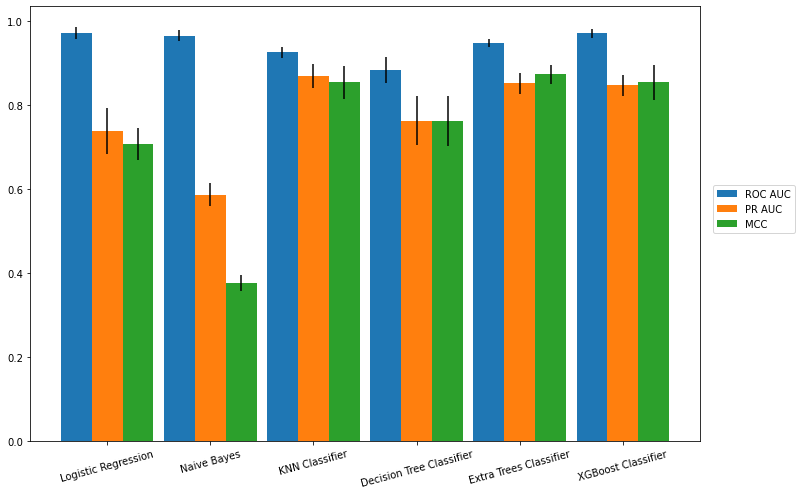

In [36]:
idx = np.arange(df_cv_statistics.shape[0])
width = 0.3
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(idx, df_cv_statistics.aucroc_mean, width, yerr=df_cv_statistics.aucroc_std)
ax.bar(idx + width, df_cv_statistics.aucpr_mean, width, yerr=df_cv_statistics.aucpr_std)
ax.bar(idx + 2 * width, df_cv_statistics.matthews_mean, width, yerr=df_cv_statistics.matthews_std)
ax.set_xticks(idx + width)
ax.set_xticklabels(df_cv_statistics.index, rotation=15)
ax.legend(['ROC AUC', 'PR AUC', 'MCC'], bbox_to_anchor=(1.15, 0.6))
fig.savefig('Documentation/images/cv_scores.jpg', dpi=100)
plt.show()

Based on the figure above, we can say that __ROC AUC__ is a homogeneous metric both within the models and among the models. In other words, all models have similar __ROC AUC__ score for each fold of CV. Moreover, there is no significant difference among the models.

However, __PR AUC__ is a heterogeneous metric where the scores changes among the models, as well as within the models. Besides, there are significant differences between two metrics.

The main reason may be the optimistic behavior of __ROC AUC__ under extremely imbalanced class distribution. For this reason, we will continue with __PR AUC__ metric.

* Matthews CC and PR AUC are pretty close to each other regardless of the algorithm, except for Naive Bayes.
* All algorithms performed well concerning ROC AUC, which is suspicious when comparing Matthews CC and PR AUC results.
* As discussed in [the Metrics](#The-Metrics), ROC scores may report optimistic results under extreme class imbalance. We may experience that phenomenon in the validation scores. It may be an explanation for the awkward situation in Naive Bayes' performance.
* ROC has the least standard deviation, which means it is the most consistent metric. However, it may be due to the optimistic behavior of the metric under extreme class imbalance.
* Naive Bayes will be dropped from the algorithms, as well as ROC from the metrics.

[Go to Table of Contents](#Table-of-Contents)

### Hyperparameter Tuning

In [37]:
# dict for keeping hyperparameter tuning results both for original
# and resampled data
best_scores = {}

#### Logistic Regression

In [38]:
# define hyperparameter space
C_values = np.logspace(-4, 4, 9)
class_weight = ['balanced', None]

# define Pipeline for LR
lr_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                          ('lr', LogisticRegression())])

# define grid search
lr_grid = {'lr__C':C_values, 'lr__class_weight':class_weight}
grid_search = GridSearchCV(
    estimator=lr_pipe, param_grid=lr_grid, n_jobs=-1, cv=cv, scoring=aucpr_scorer)
grid_result = grid_search.fit(X1_train, y_train)

# summarize results
print(f"{'Best':7}:", end=' ')
print(f'{grid_result.best_score_:.3f} using {grid_result.best_params_}')
best_scores['Logistic Regression'] = [grid_result.best_score_]
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
rest_scores = []
for mean, std, param in zip(means, stds, params):
    if param == {'lr__C': 1.0, 'lr__class_weight': None}:
        print(f'Default: {mean:.3f} using {param}')
    else:
        rest_scores.append(f'{mean:.3f} ({std:.3f}) with: {param}')
print('-'*81)
_ = [print(score) for score in rest_scores]

Best   : 0.745 using {'lr__C': 0.001, 'lr__class_weight': None}
Default: 0.738 using {'lr__C': 1.0, 'lr__class_weight': None}
---------------------------------------------------------------------------------
0.724 (0.045) with: {'lr__C': 0.0001, 'lr__class_weight': 'balanced'}
0.736 (0.045) with: {'lr__C': 0.0001, 'lr__class_weight': None}
0.727 (0.040) with: {'lr__C': 0.001, 'lr__class_weight': 'balanced'}
0.745 (0.052) with: {'lr__C': 0.001, 'lr__class_weight': None}
0.731 (0.040) with: {'lr__C': 0.01, 'lr__class_weight': 'balanced'}
0.737 (0.054) with: {'lr__C': 0.01, 'lr__class_weight': None}
0.731 (0.039) with: {'lr__C': 0.1, 'lr__class_weight': 'balanced'}
0.738 (0.055) with: {'lr__C': 0.1, 'lr__class_weight': None}
0.730 (0.041) with: {'lr__C': 1.0, 'lr__class_weight': 'balanced'}
0.730 (0.041) with: {'lr__C': 10.0, 'lr__class_weight': 'balanced'}
0.738 (0.055) with: {'lr__C': 10.0, 'lr__class_weight': None}
0.730 (0.041) with: {'lr__C': 100.0, 'lr__class_weight': 'balanced'}
0.

#### $k$-NN Classifier

In [39]:
# define hyperparameter space
n_values = [2, 3, 4, 5, 10, 20]

# define Pipeline for KNN
knn_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                           ('knn', KNeighborsClassifier())])


# define grid search
knn_grid = {'knn__n_neighbors': n_values}
grid_search = GridSearchCV(
    estimator=knn_pipe, param_grid=knn_grid, n_jobs=-1, cv=cv, scoring=aucpr_scorer)
grid_result = grid_search.fit(X1_train, y_train)

# summarize results
print(f"{'Best':7}:", end=' ')
print(f'{grid_result.best_score_:.3f} using {grid_result.best_params_}')
best_scores['KNN Classifier'] = [grid_result.best_score_]
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
rest_scores = []
for mean, std, param in zip(means, stds, params):
    if param == {'knn__n_neighbors': 5}:
        print(f'Default: {mean:.3f} using {param}')
    else:
        rest_scores.append(f'{mean:.3f} ({std:.3f}) with: {param}')
print('-'*81)
_ = [print(score) for score in rest_scores]

Best   : 0.873 using {'knn__n_neighbors': 3}
Default: 0.870 using {'knn__n_neighbors': 5}
---------------------------------------------------------------------------------
0.861 (0.037) with: {'knn__n_neighbors': 2}
0.873 (0.029) with: {'knn__n_neighbors': 3}
0.870 (0.030) with: {'knn__n_neighbors': 4}
0.872 (0.024) with: {'knn__n_neighbors': 10}
0.852 (0.031) with: {'knn__n_neighbors': 20}


[Go to Table of Contents](#Table-of-Contents)

#### Decision Tree Classifier

In [40]:
dt = DecisionTreeClassifier()

# define hyperparameter space
max_features = ['sqrt', 'log2', None]
class_weight = ['balanced', None]

# define grid search
dt_grid = dict(max_features=max_features,
            class_weight=class_weight)
grid_search = GridSearchCV(
    estimator=dt, param_grid=dt_grid, n_jobs=-1, cv=cv, scoring=aucpr_scorer)
grid_result = grid_search.fit(X1_train, y_train)

# summarize results
print(f"{'Best':7}:", end=' ')
print(f'{grid_result.best_score_:.3f} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
rest_scores = []
for mean, std, param in zip(means, stds, params):
    if param == {'class_weight': None, 'max_features': None}:
        print(f'Default: {mean:.3f} using {param}')
    else:
        rest_scores.append(f'{mean:.3f} ({std:.3f}) with: {param}')
print('-' * 81)
_ = [print(score) for score in rest_scores]

Best   : 0.795 using {'class_weight': None, 'max_features': 'log2'}
Default: 0.770 using {'class_weight': None, 'max_features': None}
---------------------------------------------------------------------------------
0.785 (0.017) with: {'class_weight': 'balanced', 'max_features': 'sqrt'}
0.770 (0.031) with: {'class_weight': 'balanced', 'max_features': 'log2'}
0.779 (0.053) with: {'class_weight': 'balanced', 'max_features': None}
0.784 (0.027) with: {'class_weight': None, 'max_features': 'sqrt'}
0.795 (0.017) with: {'class_weight': None, 'max_features': 'log2'}


[Go to Table of Contents](#Table-of-Contents)

#### Extra Trees Classifier

In [41]:
et = ExtraTreesClassifier()

# define hyperparameter space
n_estimators = [10, 100, 500]
max_features = ['sqrt', 'log2']
class_weight = ['balanced', None]

# define grid search
et_grid = dict(n_estimators=n_estimators,
            max_features=max_features,
            class_weight=class_weight)
grid_search = GridSearchCV(
    estimator=et, param_grid=et_grid, n_jobs=-1, cv=cv, scoring=aucpr_scorer)
grid_result = grid_search.fit(X1_train, y_train)

# summarize results
print(f"{'Best':7}:", end=' ')
print(f'{grid_result.best_score_:.3f} using {grid_result.best_params_}')
best_scores['Extra Trees Classifier'] = [grid_result.best_score_]
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
rest_scores = []
for mean, std, param in zip(means, stds, params):
    if param == {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 100}:
        print(f'Default: {mean:.3f} using {param}')
    else:
        rest_scores.append(f'{mean:.3f} ({std:.3f}) with: {param}')
print('-' * 81)
_ = [print(score) for score in rest_scores]

Best   : 0.863 using {'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 10}
Default: 0.854 using {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 100}
---------------------------------------------------------------------------------
0.856 (0.033) with: {'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 10}
0.854 (0.020) with: {'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 100}
0.855 (0.025) with: {'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 500}
0.863 (0.028) with: {'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 10}
0.857 (0.023) with: {'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 100}
0.857 (0.026) with: {'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 500}
0.853 (0.027) with: {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 10}
0.857 (0.027) with: {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 500

[Go to Table of Contents](#Table-of-Contents)

#### XGBoost Classifier

In [42]:
xgb = XGBClassifier()

# define hyperparameter space
eta = [0.01, 0.1, 0.3, 0.5, 1]
colsample_bytree = [0.2, 0.4, 0.6, 0.8, 1.0]

# define grid search
xgb_grid = dict(eta=eta, colsample_bytree=colsample_bytree)
grid_search = GridSearchCV(
    estimator=xgb, param_grid=xgb_grid, n_jobs=-1, cv=cv, scoring=aucpr_scorer)
grid_result = grid_search.fit(X1_train, y_train)

# summarize results
print(f"{'Best':7}:", end=' ')
print(f'{grid_result.best_score_:.3f} using {grid_result.best_params_}')
best_scores['XGBoost Classifier'] = [grid_result.best_score_]
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
rest_scores = []
for mean, std, param in zip(means, stds, params):
    if param == {'colsample_bytree': 1.0, 'eta': 0.3}:
        print(f'Default: {mean:.3f} using {param}')
    else:
        rest_scores.append(f'{mean:.3f} ({std:.3f}) with: {param}')
print('-' * 81)
_ = [print(score) for score in rest_scores]

Best   : 0.854 using {'colsample_bytree': 0.4, 'eta': 0.1}
Default: 0.848 using {'colsample_bytree': 1.0, 'eta': 0.3}
---------------------------------------------------------------------------------
0.812 (0.021) with: {'colsample_bytree': 0.2, 'eta': 0.01}
0.847 (0.028) with: {'colsample_bytree': 0.2, 'eta': 0.1}
0.844 (0.031) with: {'colsample_bytree': 0.2, 'eta': 0.3}
0.833 (0.034) with: {'colsample_bytree': 0.2, 'eta': 0.5}
0.828 (0.031) with: {'colsample_bytree': 0.2, 'eta': 1}
0.830 (0.022) with: {'colsample_bytree': 0.4, 'eta': 0.01}
0.854 (0.027) with: {'colsample_bytree': 0.4, 'eta': 0.1}
0.854 (0.029) with: {'colsample_bytree': 0.4, 'eta': 0.3}
0.850 (0.026) with: {'colsample_bytree': 0.4, 'eta': 0.5}
0.835 (0.038) with: {'colsample_bytree': 0.4, 'eta': 1}
0.841 (0.027) with: {'colsample_bytree': 0.6, 'eta': 0.01}
0.853 (0.030) with: {'colsample_bytree': 0.6, 'eta': 0.1}
0.850 (0.028) with: {'colsample_bytree': 0.6, 'eta': 0.3}
0.853 (0.027) with: {'colsample_bytree': 0.6, '

[Go to Table of Contents](#Table-of-Contents)

## Resampling Methods

We applied SMOTEENN - Synthetic Minority Oversampling Technique and Edited Nearest Neighbours - to address the data set's imbalanced class distribution. Even though using an undersampling method can address the imbalanced structure, it will reduce the number of genuine transactions by deleting the valid data points. However, we prefer to combine an oversampling method with an undersampling method for best performance. First, it will increase the number of fraudulent transactions by generating synthetic data points. Then, it will clear the boundary for better classification performance. 

On the other hand, we experienced the following sampling methods before we come to final decision:
* One Sided Selection - OSS (Under-sampling) 
* Neighborhood Cleaning Rule - NCR (Under-sampling)
* Synthetic Minority Oversampling Technique - SMOTE (Over-sampling)
* Synthetic Minority Oversampling Technique and Edited Nearest Neighbours – SMOTEENN
* Synthetic Minority Oversampling Technique with Tomek’s Links - SMOTETomek 

For more information, please refer to [Imblearn User Guide](https://imbalanced-learn.org/stable/over_sampling.html#).

### SMOTEENN

In [43]:
sme = SMOTEENN(random_state=1)
X1_train_res, y_train_res = sme.fit_resample(X1_train, y_train)

In [44]:
print(f"""
    Resampled training set has {y_train_res.sum():,} fraudulent transactions.
    Distribution of the positive class in the resampled training set: {
(y_train_res[y_train_res == 1].size/y_train_res.size)*100:.2f}%
    """)


    Resampled training set has 226,003 fraudulent transactions.
    Distribution of the positive class in the resampled training set: 50.05%
    


### Cross-Validation (Resampled)

In [45]:
# define objects - lm algorithms
lr = LogisticRegression()
knn = KNeighborsClassifier()
et = ExtraTreesClassifier()
xgb = XGBClassifier()
# (model_name, model)
estimators = [('Logistic Regression', lr), ('KNN Classifier', knn),
              ('Extra Trees Classifier', et), ('XGBoost Classifier', xgb)]

In [46]:
cv_scores_resampled = {}
for (name, clf) in estimators:
    if name in ['Logistic Regression', 'KNN Classifier']:
        pipeline = imblearn_Pipeline(steps=[
            ('smote', SMOTEENN(random_state=1)),
            ('scaler', StandardScaler()),
            (name, clf)])
        cv_score = cross_validate(estimator=pipeline,
                                   X=X1_train,
                                   y=y_train,
                                   scoring={
                                       'aucpr': aucpr_scorer,
                                       'matthews': matthews_scorer
                                   },
                                   cv=cv,
                                   n_jobs=-1)
    else:
        pipeline = imblearn_Pipeline(steps=[
            ('smote', SMOTEENN(random_state=1)),
            (name, clf)])
        cv_score = cross_validate(estimator=pipeline,
                                   X=X1_train,
                                   y=y_train,
                                   scoring={
                                       'aucpr': aucpr_scorer,
                                       'matthews': matthews_scorer
                                   },
                                   cv=cv,
                                   n_jobs=-1)
    cv_scores_resampled[name] = cv_score

In [ ]:
pickle.dump(cv_scores_resampled, open('cv_scores_resampled.pickle', 'wb'))

In [47]:
df_cv_res_statistics = get_df_statistics(cv_scores_resampled, calculate_roc=False)

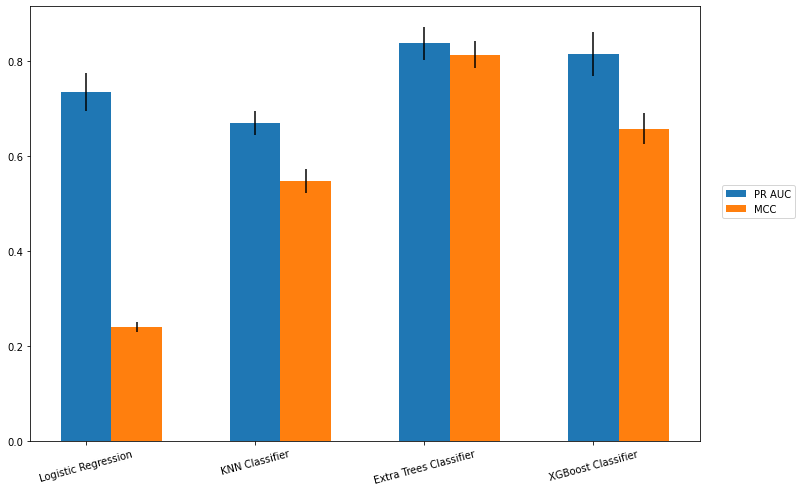

In [48]:
idx = np.arange(df_cv_res_statistics.shape[0])
width = 0.3
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(idx + width, df_cv_res_statistics.aucpr_mean, width, yerr=df_cv_res_statistics.aucpr_std)
ax.bar(idx + 2 * width, df_cv_res_statistics.matthews_mean, width, yerr=df_cv_res_statistics.matthews_std)
ax.set_xticks(idx + width)
ax.set_xticklabels(df_cv_res_statistics.index, rotation=15)
ax.legend(['PR AUC', 'MCC'], bbox_to_anchor=(1.15, 0.6))
fig.savefig('Documentation/images/cv_scores_resampling.jpg', dpi=100)
plt.show()

[Go to Table of Contents](#Table-of-Contents)

### Hyperparameter Tuning (Resampled)

#### Logistic Regression  (Resampled)

In [49]:
# define hyperparameter space
C_values = np.logspace(-4, 4, 9)
class_weight = ['balanced', None]

# define Pipeline for LR
lr_pipe = imblearn_Pipeline(steps=[
    ('smote', SMOTEENN(random_state=1)),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())])

# define grid search
lr_grid = {'lr__C':C_values, 'lr__class_weight':class_weight}
grid_search = GridSearchCV(
    estimator=lr_pipe, param_grid=lr_grid, n_jobs=-1, cv=cv, scoring=aucpr_scorer)
grid_result = grid_search.fit(X1_train, y_train)

# summarize results
print(f"{'Best':7}:", end=' ')
print(f'{grid_result.best_score_:.3f} using {grid_result.best_params_}')
best_scores['Logistic Regression'].append(grid_result.best_score_)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
rest_scores = []
for mean, std, param in zip(means, stds, params):
    if param == {'lr__C': 1.0, 'lr__class_weight': None}:
        print(f'Default: {mean:.3f} using {param}')
    else:
        rest_scores.append(f'{mean:.3f} ({std:.3f}) with: {param}')
print('-'*81)
_ = [print(score) for score in rest_scores]

Best   : 0.735 using {'lr__C': 1000.0, 'lr__class_weight': None}
Default: 0.734 using {'lr__C': 1.0, 'lr__class_weight': None}
---------------------------------------------------------------------------------
0.726 (0.038) with: {'lr__C': 0.0001, 'lr__class_weight': 'balanced'}
0.726 (0.038) with: {'lr__C': 0.0001, 'lr__class_weight': None}
0.713 (0.039) with: {'lr__C': 0.001, 'lr__class_weight': 'balanced'}
0.713 (0.039) with: {'lr__C': 0.001, 'lr__class_weight': None}
0.725 (0.042) with: {'lr__C': 0.01, 'lr__class_weight': 'balanced'}
0.725 (0.042) with: {'lr__C': 0.01, 'lr__class_weight': None}
0.729 (0.046) with: {'lr__C': 0.1, 'lr__class_weight': 'balanced'}
0.729 (0.046) with: {'lr__C': 0.1, 'lr__class_weight': None}
0.734 (0.041) with: {'lr__C': 1.0, 'lr__class_weight': 'balanced'}
0.735 (0.040) with: {'lr__C': 10.0, 'lr__class_weight': 'balanced'}
0.735 (0.040) with: {'lr__C': 10.0, 'lr__class_weight': None}
0.735 (0.040) with: {'lr__C': 100.0, 'lr__class_weight': 'balanced'}
0

[Go to Table of Contents](#Table-of-Contents)

#### $k$-NN Classifier  (Resampled)

In [50]:
# define hyperparameter space
n_values = [2, 3, 4, 5, 10, 20]

# define Pipeline for KNN
knn_pipe = imblearn_Pipeline(steps=[
    ('smote', SMOTEENN(random_state=1)),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())])


# define grid search
knn_grid = {'knn__n_neighbors': n_values}
grid_search = GridSearchCV(
    estimator=knn_pipe, param_grid=knn_grid, n_jobs=-1, cv=cv, scoring=aucpr_scorer)
grid_result = grid_search.fit(X1_train, y_train)

# summarize results
print(f"{'Best':7}:", end=' ')
print(f'{grid_result.best_score_:.3f} using {grid_result.best_params_}')
best_scores['KNN Classifier'].append(grid_result.best_score_)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
rest_scores = []
for mean, std, param in zip(means, stds, params):
    if param == {'knn__n_neighbors': 5}:
        print(f'Default: {mean:.3f} using {param}')
    else:
        rest_scores.append(f'{mean:.3f} ({std:.3f}) with: {param}')
print('-'*81)
_ = [print(score) for score in rest_scores]

Best   : 0.681 using {'knn__n_neighbors': 20}
Default: 0.670 using {'knn__n_neighbors': 5}
---------------------------------------------------------------------------------
0.675 (0.024) with: {'knn__n_neighbors': 2}
0.673 (0.025) with: {'knn__n_neighbors': 3}
0.671 (0.026) with: {'knn__n_neighbors': 4}
0.670 (0.026) with: {'knn__n_neighbors': 10}
0.681 (0.026) with: {'knn__n_neighbors': 20}


[Go to Table of Contents](#Table-of-Contents)

#### Extra Trees Classifier  (Resampled)

In [51]:
# define hyperparameter space
n_estimators = [10, 100, 500]
max_features = ['sqrt', 'log2']
class_weight = ['balanced', None]

# define pipeline for ET
et_pipe = imblearn_Pipeline(steps=[
    ('smote', SMOTEENN(random_state=1)),
    ('et', ExtraTreesClassifier())])

# define grid search
et_grid = {'et__n_estimators': n_estimators,
           'et__max_features': max_features,
           'et__class_weight': class_weight}

grid_search = GridSearchCV(
    estimator=et_pipe, param_grid=et_grid, n_jobs=-1, cv=cv, scoring=aucpr_scorer)
grid_result = grid_search.fit(X1_train, y_train)

# summarize results
print(f"{'Best':7}:", end=' ')
print(f'{grid_result.best_score_:.3f} using {grid_result.best_params_}')
best_scores['Extra Trees Classifier'].append(grid_result.best_score_)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
rest_scores = []
for mean, std, param in zip(means, stds, params):
    if param == {'et__class_weight': None, 'et__max_features': 'sqrt', 'et__n_estimators': 100}:
        print(f'Default: {mean:.3f} using {param}')
    else:
        rest_scores.append(f'{mean:.3f} ({std:.3f}) with: {param}')
print('-' * 81)
_ = [print(score) for score in rest_scores]

Best   : 0.839 using {'et__class_weight': 'balanced', 'et__max_features': 'log2', 'et__n_estimators': 500}
Default: 0.836 using {'et__class_weight': None, 'et__max_features': 'sqrt', 'et__n_estimators': 100}
---------------------------------------------------------------------------------
0.819 (0.037) with: {'et__class_weight': 'balanced', 'et__max_features': 'sqrt', 'et__n_estimators': 10}
0.834 (0.034) with: {'et__class_weight': 'balanced', 'et__max_features': 'sqrt', 'et__n_estimators': 100}
0.837 (0.028) with: {'et__class_weight': 'balanced', 'et__max_features': 'sqrt', 'et__n_estimators': 500}
0.831 (0.039) with: {'et__class_weight': 'balanced', 'et__max_features': 'log2', 'et__n_estimators': 10}
0.835 (0.035) with: {'et__class_weight': 'balanced', 'et__max_features': 'log2', 'et__n_estimators': 100}
0.839 (0.029) with: {'et__class_weight': 'balanced', 'et__max_features': 'log2', 'et__n_estimators': 500}
0.822 (0.032) with: {'et__class_weight': None, 'et__max_features': 'sqrt', '

[Go to Table of Contents](#Table-of-Contents)

#### XGBoost Classifier  (Resampled)

In [52]:
xgb = XGBClassifier()

# define hyperparameter space
eta = [0.001, 0.01, 0.1, 0.3, 0.5, 1]
colsample_bytree = [0.2, 0.4, 0.6, 0.8, 1.0]

# define pipeline for XGB
xgb_pipe = imblearn_Pipeline(steps=[
    ('smote', SMOTEENN(random_state=1)),
    ('xgb', XGBClassifier())])

# define grid search
xgb_grid = {'xgb__eta': eta, 'xgb__colsample_bytree': colsample_bytree}

grid_search = GridSearchCV(
    estimator=xgb_pipe, param_grid=xgb_grid, n_jobs=-1, cv=cv, scoring=aucpr_scorer)
grid_result = grid_search.fit(X1_train, y_train)

# summarize results
print(f"{'Best':7}:", end=' ')
print(f'{grid_result.best_score_:.3f} using {grid_result.best_params_}')
best_scores['XGBoost Classifier'].append(grid_result.best_score_)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
rest_scores = []
for mean, std, param in zip(means, stds, params):
    if param == {'xgb__colsample_bytree': 1.0, 'xgb__eta': 0.3}:
        print(f'Default: {mean:.3f} using {param}')
    else:
        rest_scores.append(f'{mean:.3f} ({std:.3f}) with: {param}')
print('-' * 81)
_ = [print(score) for score in rest_scores]

Best   : 0.822 using {'xgb__colsample_bytree': 0.8, 'xgb__eta': 0.3}
Default: 0.814 using {'xgb__colsample_bytree': 1.0, 'xgb__eta': 0.3}
---------------------------------------------------------------------------------
0.744 (0.041) with: {'xgb__colsample_bytree': 0.2, 'xgb__eta': 0.001}
0.729 (0.029) with: {'xgb__colsample_bytree': 0.2, 'xgb__eta': 0.01}
0.822 (0.024) with: {'xgb__colsample_bytree': 0.2, 'xgb__eta': 0.1}
0.812 (0.046) with: {'xgb__colsample_bytree': 0.2, 'xgb__eta': 0.3}
0.803 (0.038) with: {'xgb__colsample_bytree': 0.2, 'xgb__eta': 0.5}
0.808 (0.026) with: {'xgb__colsample_bytree': 0.2, 'xgb__eta': 1}
0.774 (0.043) with: {'xgb__colsample_bytree': 0.4, 'xgb__eta': 0.001}
0.775 (0.041) with: {'xgb__colsample_bytree': 0.4, 'xgb__eta': 0.01}
0.819 (0.038) with: {'xgb__colsample_bytree': 0.4, 'xgb__eta': 0.1}
0.814 (0.043) with: {'xgb__colsample_bytree': 0.4, 'xgb__eta': 0.3}
0.798 (0.041) with: {'xgb__colsample_bytree': 0.4, 'xgb__eta': 0.5}
0.808 (0.047) with: {'xgb__c

[Go to Table of Contents](#Table-of-Contents)

## Final Evaluation

In [53]:
temp = pd.DataFrame(best_scores)
temp = temp.T
temp.columns = ['HyperparemeterTuning', 'HyperparameterTuningSMOTEENN']
display(temp)

,HyperparemeterTuning,HyperparameterTuningSMOTEENN
Logistic Regression,0.745125,0.735264
KNN Classifier,0.872836,0.681403
Extra Trees Classifier,0.863069,0.839344
XGBoost Classifier,0.854038,0.821997


Based on the table above, we can see that algorithms perform better without resampling methods.

### Test Scores

In [54]:
# define estimators based on hyperparameter tuning
lr_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=0.001, class_weight=None))])

knn_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                      ('knn', KNeighborsClassifier(n_neighbors=3))])

et = ExtraTreesClassifier()
xgb = XGBClassifier(colsample_bytree=0.4, eta=0.1)
estimators = [('Logistic Regression', lr_pipe),
              ('KNN Classifier', knn_pipe),
              ('Extra Trees Classifier', et),
              ('XGBoost Classifier', xgb)]

In [55]:
test_scores = {}
for name, clf in estimators:
    clf.fit(X1_train, y_train)
    preds = clf.predict(X1_test)
    predprobas = clf.predict_proba(X1_test)[:, 1]
    
    # dict for storing preds and scores
    test_scores[name] = {} 
    test_scores[name]['preds'] = preds
    test_scores[name]['probas'] = predprobas
    
    # calculate scores
    precision, recall, _ = precision_recall_curve(y_test, predprobas)
    test_aucpr_score = auc(recall, precision)
    test_scores[name]['aucpr'] = test_aucpr_score
    
    test_matthews = matthews_corrcoef(y_test, preds)
    test_scores[name]['matthews'] = test_matthews

In [56]:
temp = pd.DataFrame(test_scores)
temp = temp.T
temp = temp.loc[:, ['aucpr', 'matthews']]
display(temp)

,aucpr,matthews
Logistic Regression,0.697275,0.670549
KNN Classifier,0.808451,0.823951
Extra Trees Classifier,0.772061,0.836751
XGBoost Classifier,0.757518,0.830277


In [57]:
estimators = [('KNN Classifier', knn_pipe),
              ('Extra Trees Classifier', et),
              ('XGBoost Classifier', xgb)]

In [58]:
# ensemble the classifier to see if it increase prediction power
voting_pipe = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('voting', VotingClassifier(estimators=estimators, voting='soft'))])

In [59]:
# prediction of VotingClassifier
voting_pipe.fit(X1_train, y_train)
preds_voting = voting_pipe.predict(X1_test)
print("""
    Matthews CorrCoef: {}""".format(matthews_corrcoef(y_test, preds_voting)))


    Matthews CorrCoef: 0.8433789698421696


### Confusion Matrices

In [60]:
def plot_confusion_matrix(y, predictions, title=None, ax=None, cmap='Purples',
                          cbar=False):
    """Plots Confusion Matrix

    Parameters
    ----------

    y: The target array
        Example:
        # df is a pandas dataframe with features and target variable
        # where the 'Class' is the target variable
        >>> y = df['Class'].values

    predictions: The predicted labels
        Example:
        # df is a pandas dataframe with features and target variable
        # where the 'Class' is the target variable
        >>> from sklearn.linear_model import LogisticRegresion
        >>> X = df.drop('Class', axis=1).values
        >>> y = df['Class'].values
        >>> lr = LogisticRegresion()
        >>> lr.fit(X_train, y_train)
        >>> predictions = lr.predict(X_test) # predicted labels

    title: Title of the plot
        Example:
        >>> title = 'Logistic Regression'
        >>> plot_confusion_matrix(y, predictions, title=title, ax, cmap, cbar)

    ax: An axis object
        Example:
        >>> fig, ax = plt.subplots()
        >>> plot_confusion_matrix(y, predictions, title, ax=ax)

    cmap: The color map for the confusion matrix
        Example:
        >>> import matplotlib.pyplot as plt
        >>> plt.colormaps() # prints all available color maps

    cbar: If True shows the color bar next to the confusion matrix
        Example
        >>> plot_confusion_matrix(y, predictions, title, ax=ax, cbar=True)

    Returns
    -------

    ax: Axes object
    """

    if ax is None:
        ax = plt.gca()

    cm_df = pd.DataFrame(confusion_matrix(y, predictions))

    # Use a seaborn heatmap to plot confusion matrices
    # The dataframe is transposed to make Actual values on x-axis and
    # predicted values on y-axis
    # annot = True includes the numbers in each box
    # vmin and vmax just adjusts the color value
    sns.heatmap(cm_df.T,
                annot=True,
                annot_kws={"size": 15},
                cmap=cmap,
                vmin=0,
                vmax=800,
                fmt='.0f',
                linewidths=1,
                linecolor="white",
                cbar=cbar,
                xticklabels=["Genuine", "Fraud"],
                yticklabels=["Genuine", "Fraud"],
                ax=ax)

    # adjusts the heights of the top and bottom squares of the heatmap
    # matplotlib 3.1.1 has a bug that shows only the half of the top
    # and bottom rows of the heatmap
    # bottom, top = ax.get_ylim()
    # _ = ax.set_ylim(bottom + 0.5, top - 0.5)

    # ax.set_ylabel("Predicted", fontweight='bold', fontsize=15)
    # ax.set_xlabel("Actual", fontweight='bold', fontsize=15)
    ax.set_xticklabels(["Genuine", "Fraud"], fontsize=13)
    ax.set_yticklabels(["Genuine", "Fraud"], fontsize=13)
    ax.set_title(title, fontweight='bold', pad=5)

    return ax

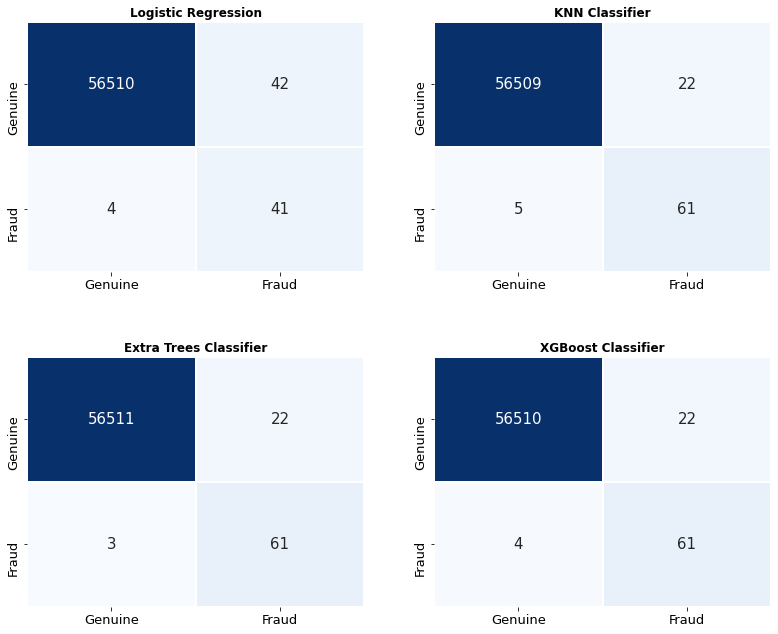

In [61]:
predictions_all_clfs = [test_scores[clf]['preds'] for clf in temp.index]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, clf in enumerate(temp.index):
    plot_confusion_matrix(y=y_test, predictions=predictions_all_clfs[idx],
                          title=clf, ax=axes[idx], cmap='Blues', cbar=False)

plt.tight_layout(5)
plt.show()   

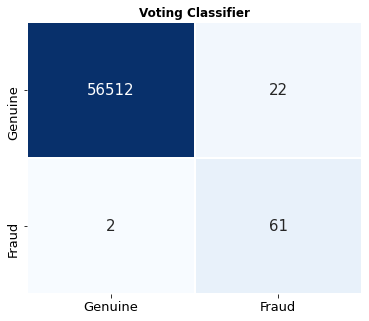

In [62]:
fig, ax = plt.subplots(figsize=(6, 5))
plot_confusion_matrix(y=y_test, predictions=preds_voting,
                      title='Voting Classifier', ax=ax,
                      cmap='Blues', cbar=False)
plt.show()

The best performing classifier is __Extra Trees__, which is slightly better than __XGBoost__.

All classifiers consistently have 22 false negative transactions. Let's explore those.

In [63]:
# calculate precision and recall for Extra Trees
print("""
    Precision Score: {0:.2f}%
    Recall Score: {1:.2f}%
""".format(
precision_score(y_test, test_scores['Extra Trees Classifier']['preds']),
recall_score(y_test, test_scores['Extra Trees Classifier']['preds'])))


    Precision Score: 0.95%
    Recall Score: 0.73%



In [64]:
# since 22 are false positive which means that they are predicted as 0
# but their true value is 0. If we subtract two arrays (y_test - preds)
# then those observations will have value of 1.
# Later find their indices and pull the observations from the data frame.
array = y_test - test_scores['Extra Trees Classifier']['preds']
idx_et = np.where(array == 1)
print(idx_et)

(array([ 4913,  7038,  9759, 11370, 14059, 17477, 19751, 20213, 20632,
       21058, 21599, 21931, 32282, 33865, 35253, 35494, 35680, 37147,
       37624, 44537, 45447, 54467], dtype=int64),)


In [65]:
array = y_test - test_scores['KNN Classifier']['preds']
idx_knn = np.where(array == 1)
print(idx_knn)

(array([ 4913,  7038,  9759, 11370, 14059, 14157, 17477, 20213, 20632,
       21058, 21599, 21931, 32282, 33865, 35253, 35494, 37147, 37624,
       40963, 44537, 45447, 54467], dtype=int64),)


In [66]:
array = y_test - test_scores['XGBoost Classifier']['preds']
idx_xgb = np.where(array == 1)
print(idx_xgb)

(array([ 4913,  7038,  9759, 11370, 14059, 17477, 19751, 20213, 20632,
       21058, 21599, 21931, 32282, 33865, 35253, 35494, 35680, 37147,
       37624, 44537, 45447, 54467], dtype=int64),)


As suspected all classifiers failed to correctly classify the same group of transactions. We will examine the time and amount info related to those transactions.

Since features are outcome of PCA, it is not possible to infer anything about these transactions from the features. 

## Remarks

* In the Hyperparameter Optimization, a narrow set of hyperparameters were tested and the best performing pair of parameters are selected to be tested for final evaluation.
* Resampling methods didn't favor the algorithms. Thus, we worked with the original data.
* Voting classifier is as good as Extra Trees classifier. For this reason, we will go with Extra Trees
* Even though algorithms have slight differences the best performing one is Extra Trees, which provided the best results in Confusion Matrix.

__NOTE!!!__ Due to the limited resources (time, computing power, data etc.) the project may not be the best or the ideal project. However, I believe that it fulfilled its objective as a first data science project, in which I played around the algorithms, parameters, resampling method(s) and did a lot of coding practice. For this reason, I do not have any claim to do the best project in terms of data science but I do have a claim to do the best I can do for an apprentice in the field of data science. Please do contact with me via [LinkedIn](https://www.linkedin.com/in/alirifatkaya/) for any comment and/or constructive criticism. 